# Preliminaries

In [1]:
#import libraries
import pandas as pd
print('pandas: %s' % pd.__version__)

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 150)

import numpy as np
print('geopandas: %s' % np.__version__)

# Tensorflow / Keras
import tensorflow as tf # used to access argmax function
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

import decimal
from decimal import Decimal

import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dropout,BatchNormalization,Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from keras import callbacks
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense # for creating regular densely-connected NN layer.
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,MaxPooling2D # for adding Concolutional and densely-connected NN layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

from pathlib import Path  

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import OrdinalEncoder # for encoding labels
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibrationDisplay

import sys
sys.path.append("/Users/paolo/Documents/TC/Paolo/scripts/")
from aux import extract_cyclones, extract_target, find_neighbour, extract_zeros_samples, extract_images_withCenter, extract_images_all


pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2
pandas: 1.5.0
geopandas: 1.23.2
Tensorflow/Keras: 2.10.0
pandas: 1.5.0
numpy: 1.23.2


In [2]:
def extract_images(df, variables, verbose=False):
    number_of_img, rows, cols = len(df.time.unique()), len(df.latitude.unique()), len(df.longitude.unique())
    images = np.zeros( (number_of_img, rows, cols, len(variables)) )
    
    df = df.sort_values(by=['time','latitude','longitude'])
    k=0
    
    for day in range(0,number_of_img):
        
        a=df.iloc[377*day:377*(day+1)]
        i=0
        for var in variables:
            images[day,:,:,i] = a.pivot(index='latitude', columns='longitude').sort_index(ascending=False)[var]
            i+=1
        k+=1
        if (k%100==0) & (verbose==True): print(k)
    return images

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Features Images

In [4]:
train = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/training_sets_withrealtom.csv')
val = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/validation_sets_withrealtom.csv')
test = pd.read_csv('/Users/paolo/Documents/TC_old/data/NewData_csv/test_sets_withrealtom.csv')
test = test.loc[test.time>='2016-04-01']

train['shear'] = train.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)
val['shear'] = val.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)
test['shear'] = test.apply(lambda x: np.sqrt((x.u_200-x.u_850)**2 + (x.v_200-x.v_850)**2),axis=1)

scaler = StandardScaler()

cols_to_std = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']
train_std,val_std,test_std = train,val,test

# apply standardization on numerical features
train_std[cols_to_std] = scaler.fit_transform(train[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])
val_std[cols_to_std] = scaler.transform(val[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])
test_std[cols_to_std] = scaler.transform(test[[ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']])

#training set has 11323 days
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']
train_img_std = extract_images(train_std, variables, verbose=False)
val_img_std = extract_images(val_std, variables, verbose=False)
test_img_std = extract_images(test_std, variables, verbose=False)
#test_img_std_old = extract_images(test_std.loc[test.time<='2019-12-01'], variables, verbose=False)
print(train_img_std.shape,val_img_std.shape,test_img_std.shape)


(11323, 13, 29, 9) (1826, 13, 29, 9) (2466, 13, 29, 9)


In [5]:
variables = [ 'vo', 'r', 'u_200', 'u_850', 'v_200','v_850', 'ttr','sst','shear']

test_img_std_before20191201 = extract_images(test_std.loc[test_std.time<='2019-12-01'], variables, verbose=False)
test_img_std_before20191201.shape

(1340, 13, 29, 9)

# Old targets images

In [6]:
### Extract old images, 24h aggregations, one day ahead

test_old = pd.read_csv('/Users/paolo/Documents/TC/data/test_real_tom_target.csv').drop(columns=['Unnamed: 0'])
train_old = pd.read_csv('/Users/paolo/Documents/TC/data/training_real_tom_target.csv').drop(columns=['Unnamed: 0'])
val_old = pd.read_csv('/Users/paolo/Documents/TC/data/validation_real_tom_target.csv').drop(columns=['Unnamed: 0'])
test_old = test_old.loc[test_old.time>='2016-04-01']

y_train_old = train_old.loc[:,['Real_tom_lsm','latitude','longitude','time']]
y_val_old = val_old.loc[:,['Real_tom_lsm','latitude','longitude','time']]
y_test_old = test_old.loc[:,['Real_tom_lsm','latitude','longitude','time']]

variables_old = [ 'Real_tom_lsm']
y_train_img_old = extract_images(y_train_old, variables_old, verbose=False)
y_val_img_old = extract_images(y_val_old, variables_old, verbose=False)
y_test_img_old = extract_images(y_test_old, variables_old, verbose=False)
print(y_train_img_old.shape,y_val_img_old.shape,y_test_img_old.shape)

(11323, 13, 29, 1) (1826, 13, 29, 1) (1340, 13, 29, 1)


In [1]:
import pandas as pd
test_old = pd.read_csv('/Users/paolo/Documents/TC/data/test_real_tom_target.csv').drop(columns=['Unnamed: 0'])
test_old

,time,latitude,longitude,vo,r,u_200,u_850,v_200,v_850,ttr,sst,lsm,Real_tom_lsm
0,2016-01-01,0.0,20.0,0.000011,80.796135,-2.052292,0.008678,4.996910,-1.678764,-272.04962,0.00000,0.0,0.0
1,2016-01-01,0.0,22.5,0.000011,77.748420,-4.445312,0.740505,7.517281,0.792618,-250.63333,0.00000,0.0,0.0
2,2016-01-01,0.0,25.0,-0.000001,71.178825,-3.778427,1.056324,9.333221,0.688252,-229.52519,0.00000,0.0,0.0
3,2016-01-01,0.0,27.5,-0.000005,73.585754,-4.695709,1.236446,9.589882,0.555519,-240.80815,0.00000,0.0,0.0
4,2016-01-01,0.0,30.0,-0.000016,72.382780,-4.002563,0.734211,5.410950,-1.086350,-262.45557,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539482,2019-12-01,-30.0,80.0,0.000006,2.637233,33.277840,5.379345,-0.286896,5.558327,-277.60870,294.14987,0.0,0.0
539483,2019-12-01,-30.0,82.5,-0.000020,23.660923,34.272537,6.438683,-13.026535,2.857349,-270.80573,294.23798,0.0,0.0
539484,2019-12-01,-30.0,85.0,-0.000019,46.051540,35.755882,7.248966,-18.870102,-3.349407,-249.43092,294.26890,0.0,0.0
539485,2019-12-01,-30.0,87.5,-0.000014,55.855648,34.069664,6.349327,-18.801796,-8.172478,-239.36870,294.36630,0.0,0.0


# CNN 1 day lag

## old target

In [7]:
model = Sequential()
model.add(layers.Input(shape=(13, 29, 9)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((0,1),(0,1))))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)


2023-03-21 13:45:06.281553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-21 13:45:06.284013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 29, 8)         656       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 15, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 15, 8)          584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 30, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 30, 1)         73        
                                                                 
 cropping2d (Cropping2D)  

In [8]:
model.fit(train_img_std, y_train_img_old, validation_data=(val_img_std,y_val_img_old),
        callbacks=[monitor],epochs=100)

Epoch 1/100


2023-03-21 13:45:08.389980: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-21 13:45:08.746336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - ETA: 0s - loss: 0.0392

2023-03-21 13:45:12.745899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - 5s 9ms/step - loss: 0.0392 - val_loss: 0.0082
Epoch 2/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0089 - val_loss: 0.0065
Epoch 3/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 4/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 5/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 6/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 7/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 8/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 9/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 10/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0061 - val_loss: 0.0051
E

39/42 [==========================>...] - ETA: 0s

2023-03-21 13:47:45.167951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 0s 6ms/step


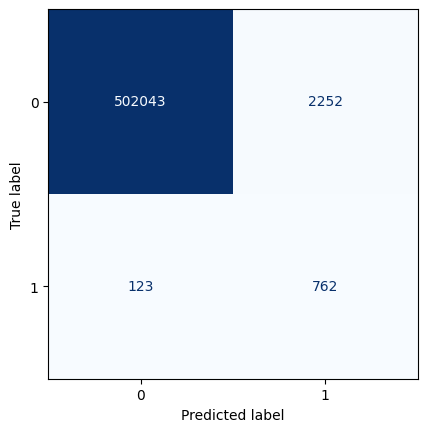

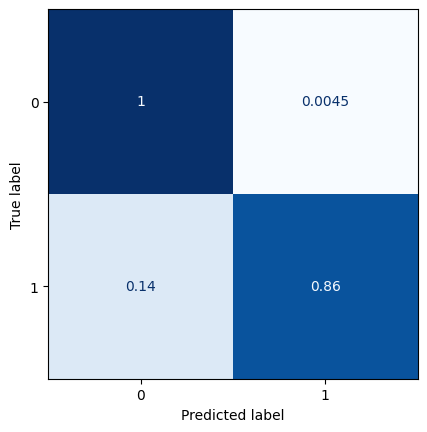

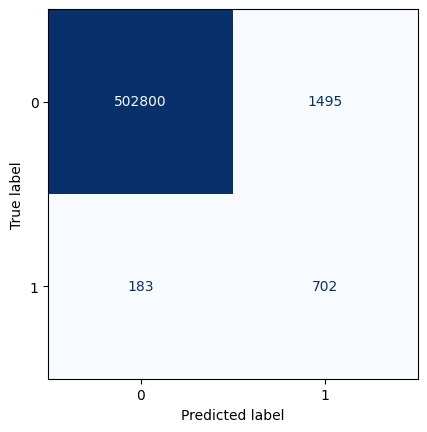

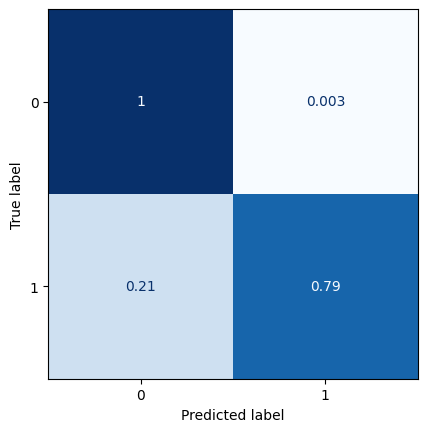

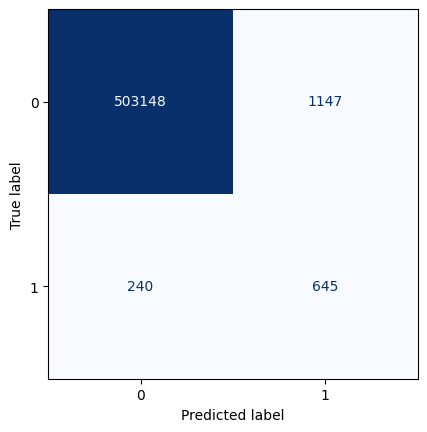

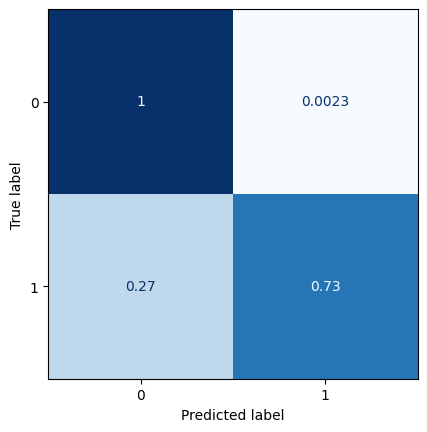

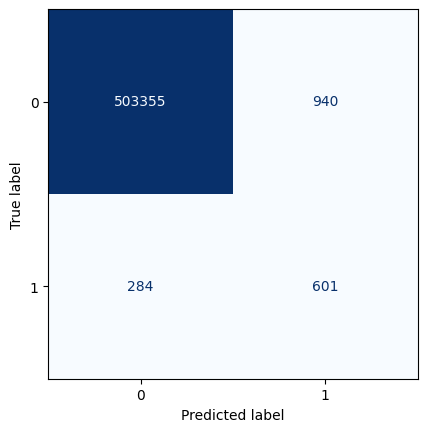

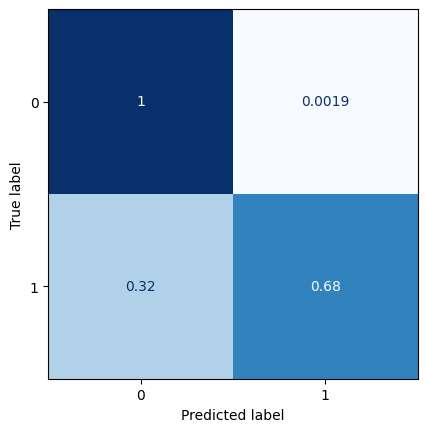

In [9]:
t = model.predict(test_img_std_before20191201)

ranges = [0.025,0.05,0.075,0.1]

for j in ranges:
    classes = []
    for i in t.reshape(-1,1):
        if i<=j: classes.append(0)
        else: classes.append(1)

# confusion matrix with threshold on 0.1, otherwise always 0 
    ConfusionMatrixDisplay(confusion_matrix(y_test_img_old.reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
    ConfusionMatrixDisplay(confusion_matrix(y_test_img_old.reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    

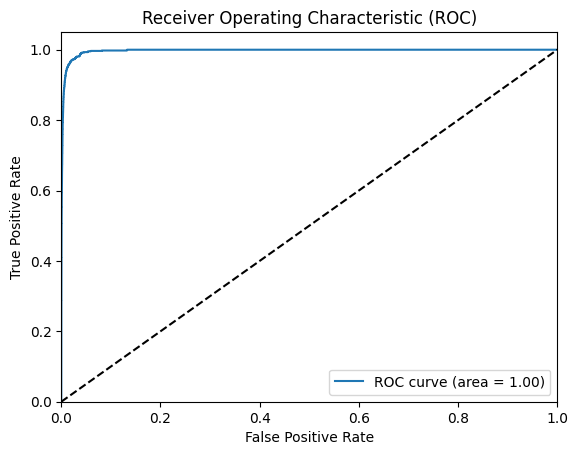

In [10]:
plot_roc(t.reshape(-1,1),y_test_img_old.reshape(-1,1))

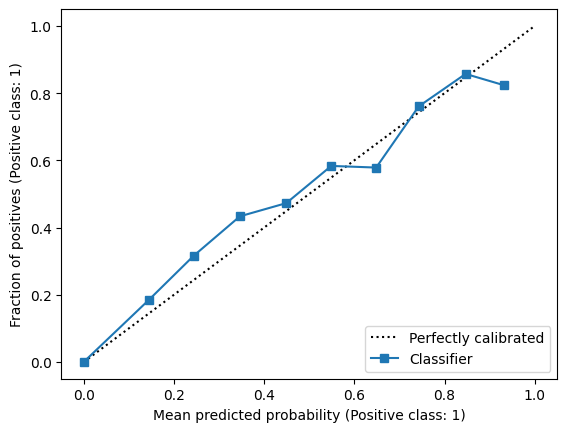

In [11]:
display = CalibrationDisplay.from_predictions(y_test_img_old.reshape(-1,1), t.reshape(-1,1), n_bins=10)

In [12]:
brier_score_loss(y_test_img_old.reshape(-1,1), np.zeros(len(y_test_img_old.reshape(-1,1))))

0.001751850825448355

In [13]:
brier_score_loss(y_test_img_old.reshape(-1,1), t.reshape(-1,1))

0.0011320201083463155

9


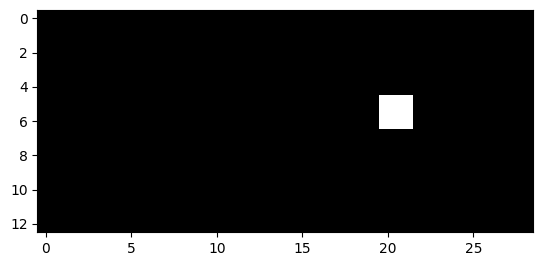

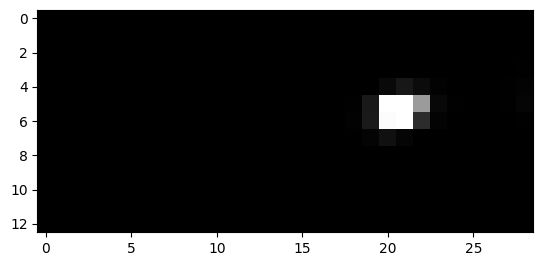

10


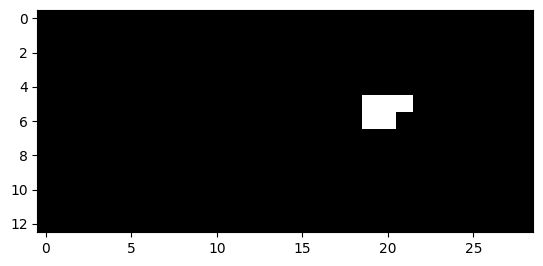

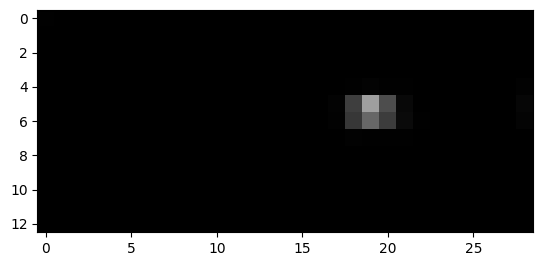

11


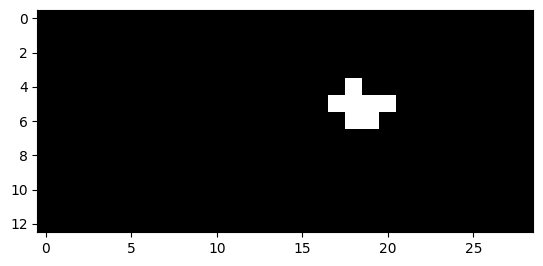

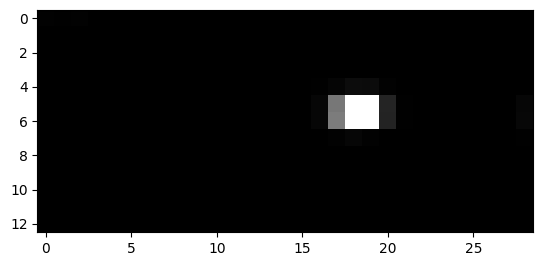

12


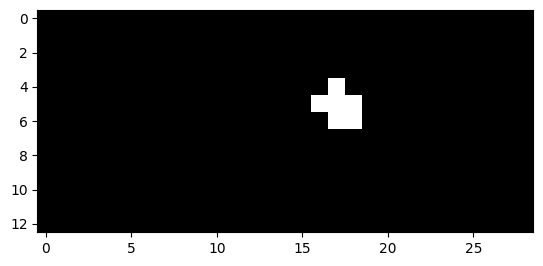

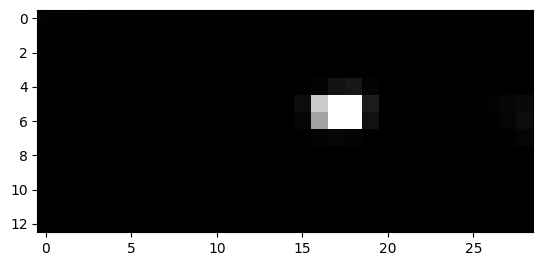

13


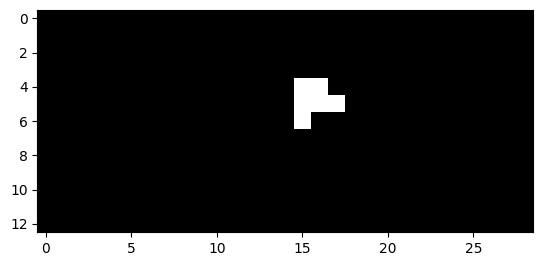

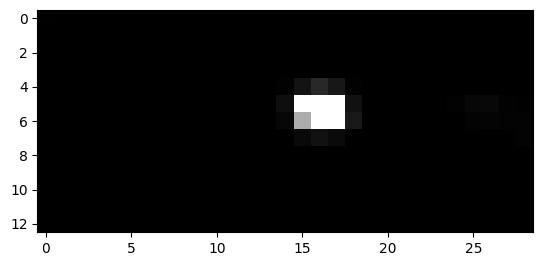

14


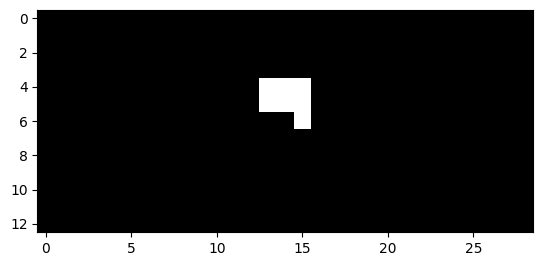

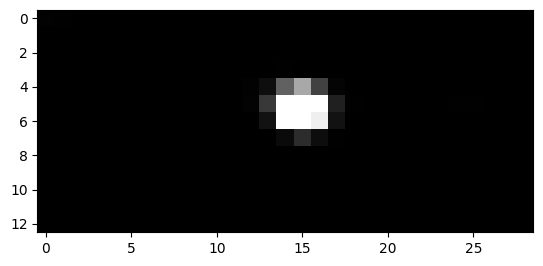

15


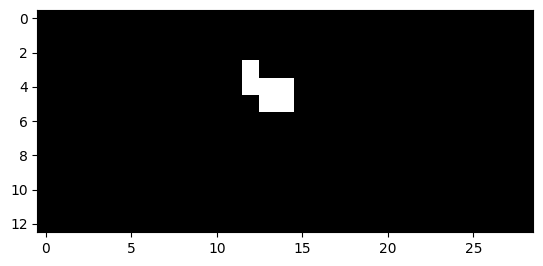

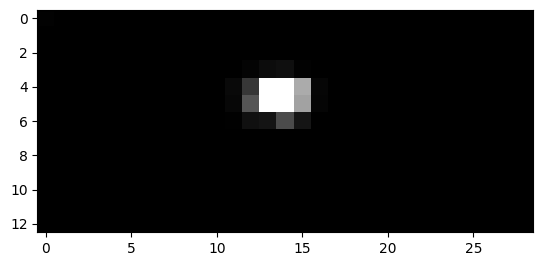

16


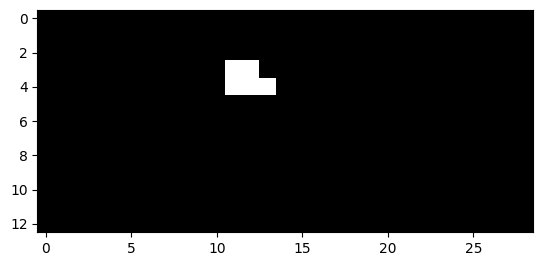

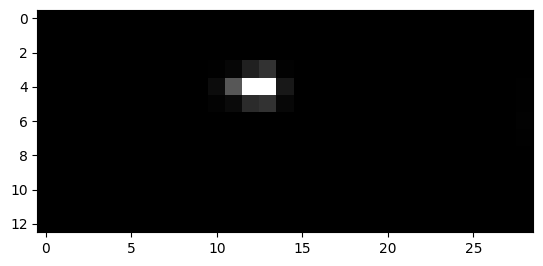

17


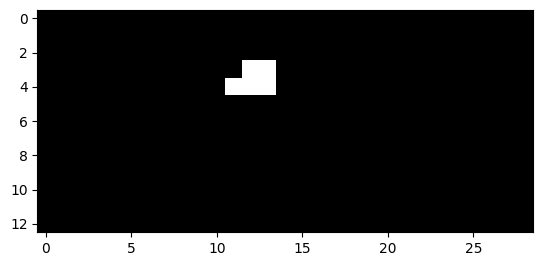

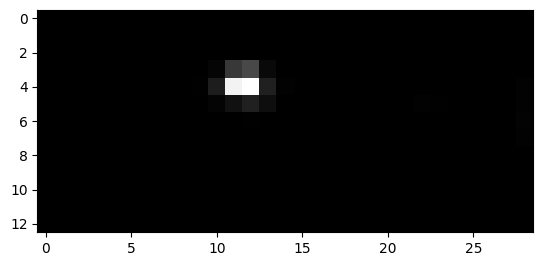

18


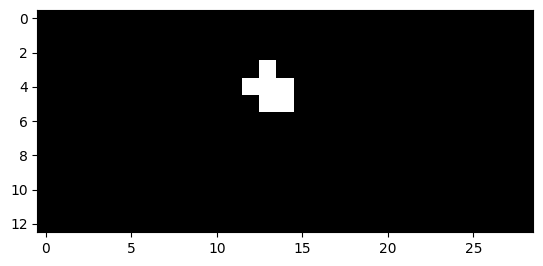

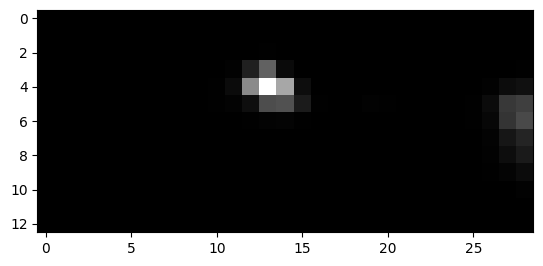

19


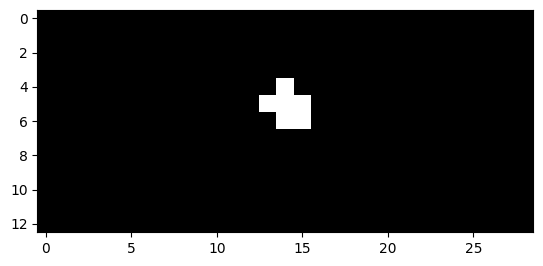

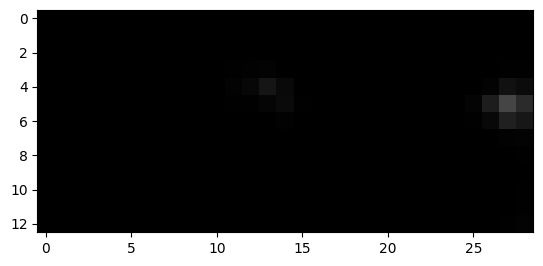

20


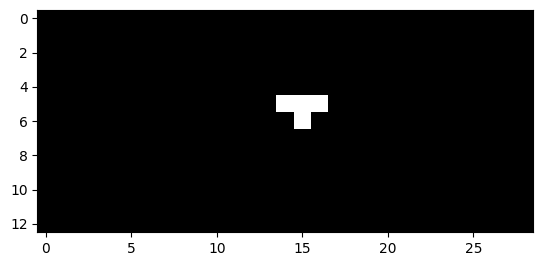

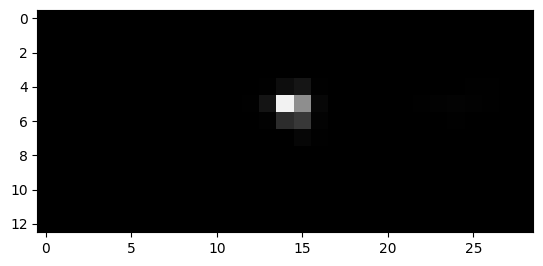

21


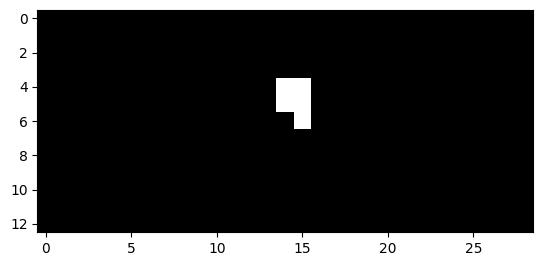

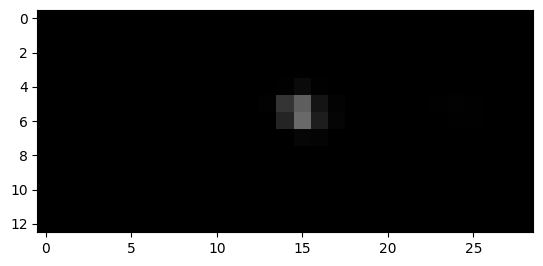

308


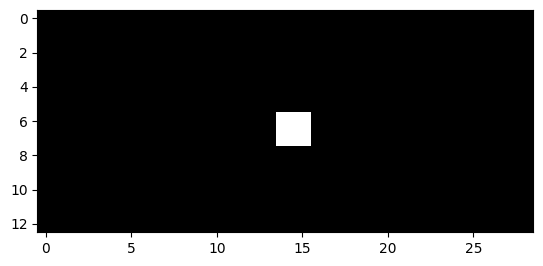

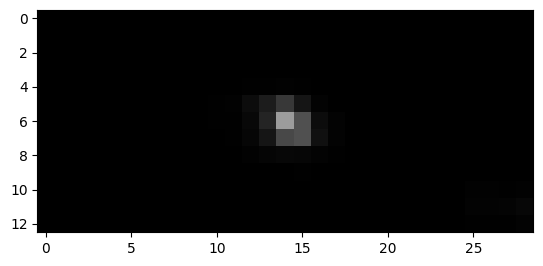

309


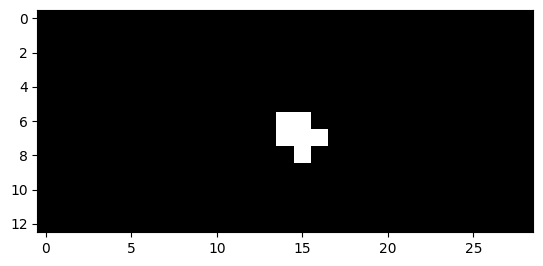

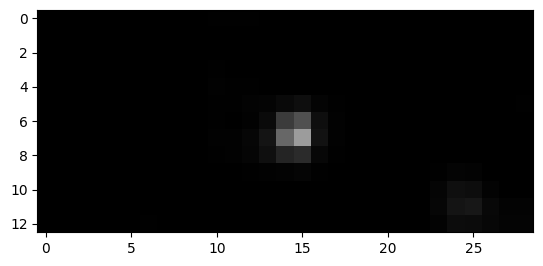

310


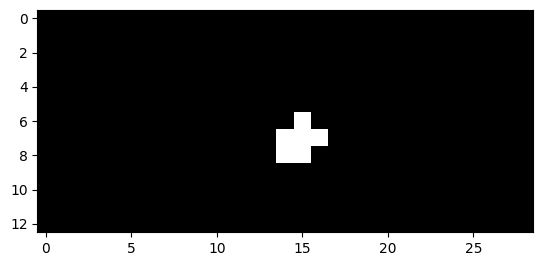

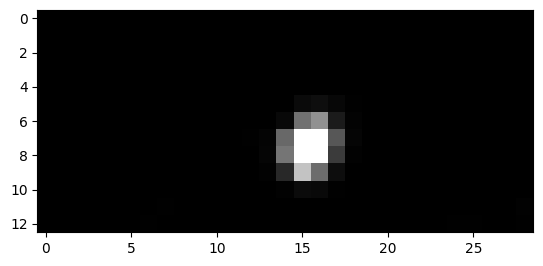

311


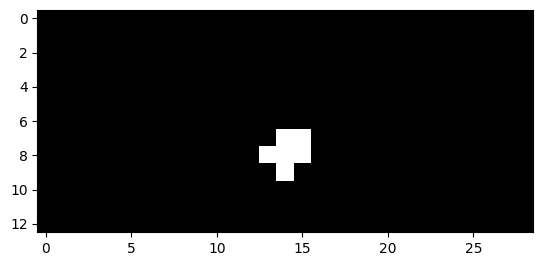

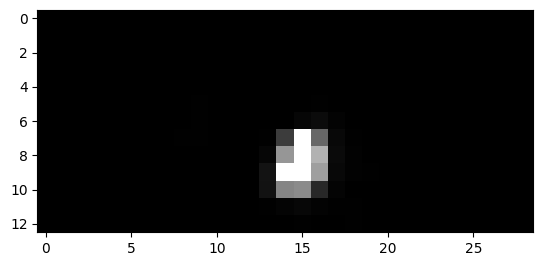

312


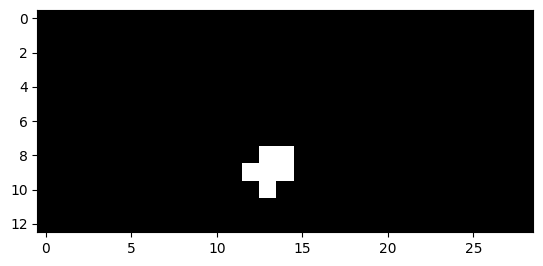

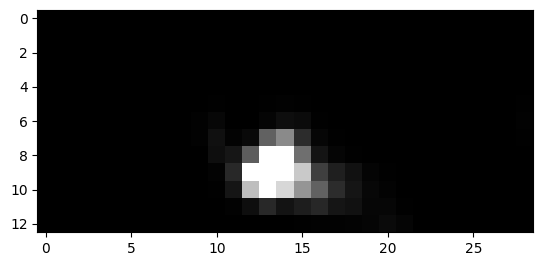

313


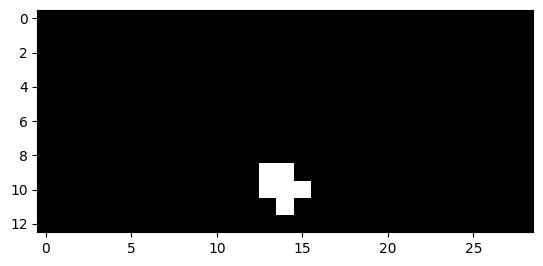

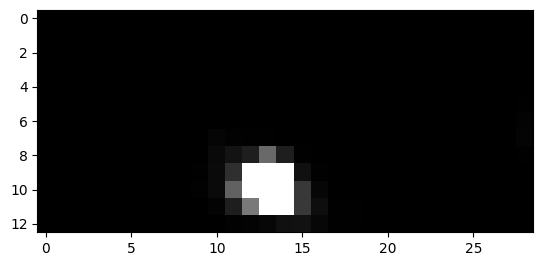

314


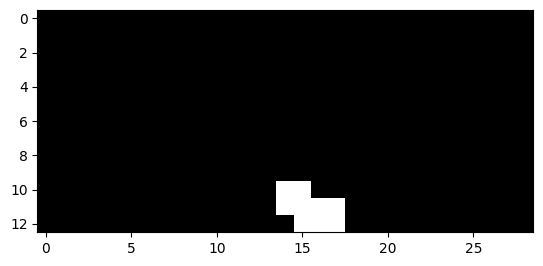

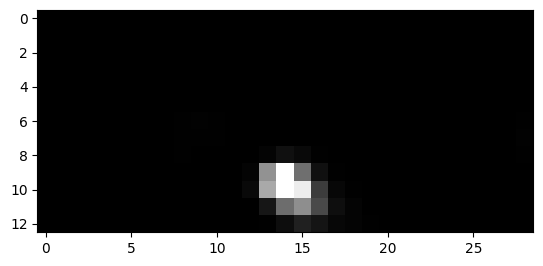

315


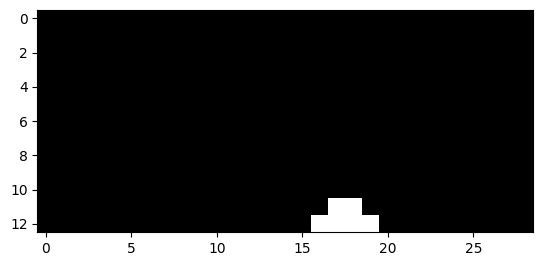

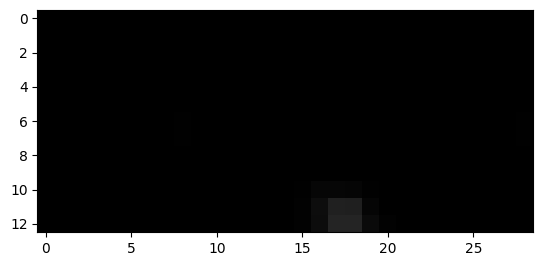

316


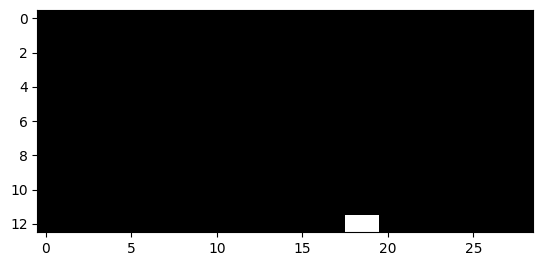

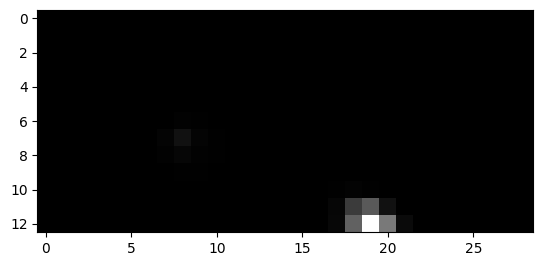

317


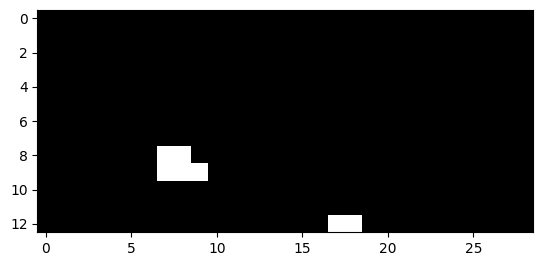

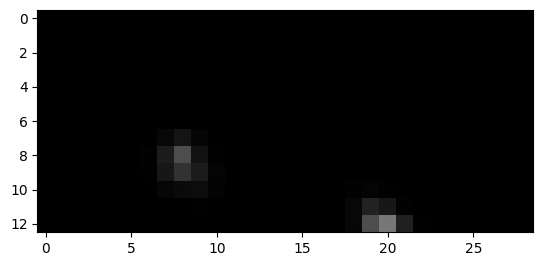

318


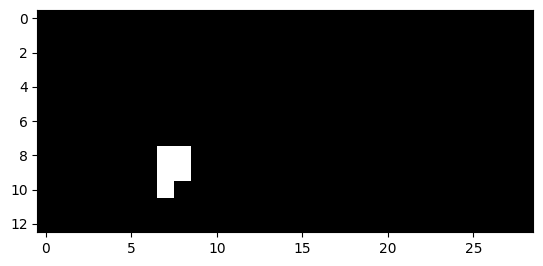

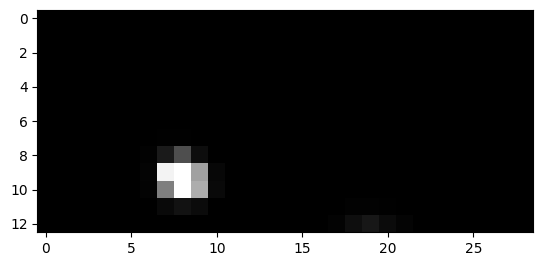

319


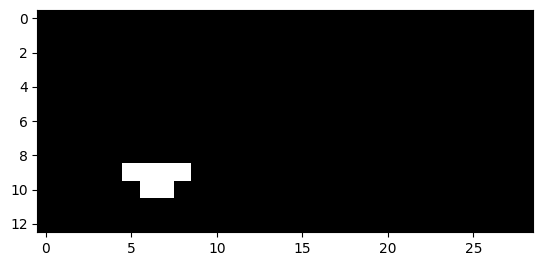

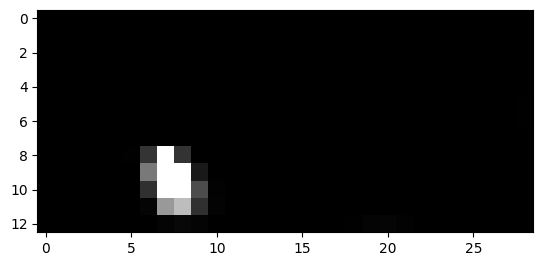

320


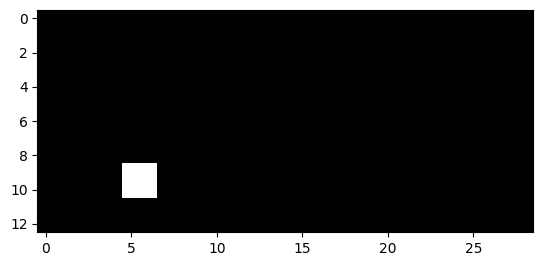

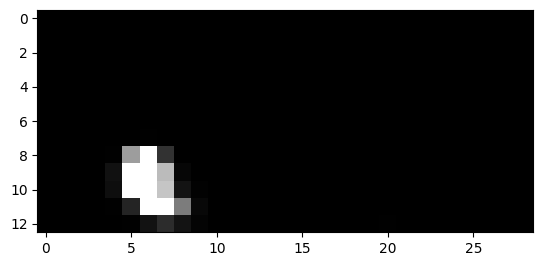

335


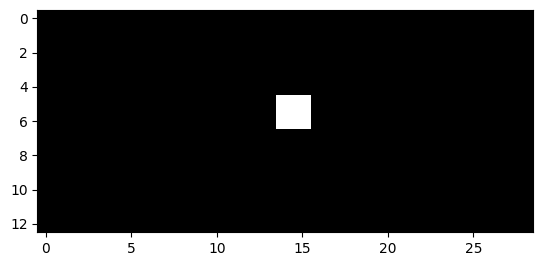

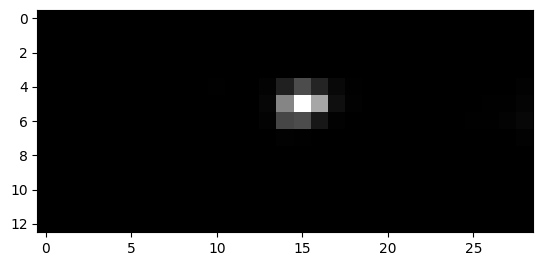

336


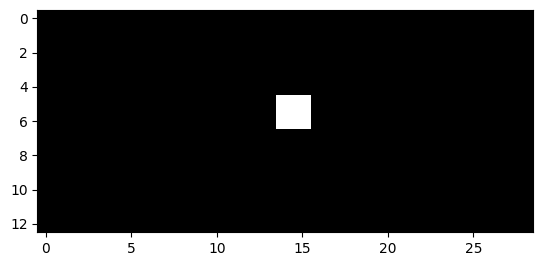

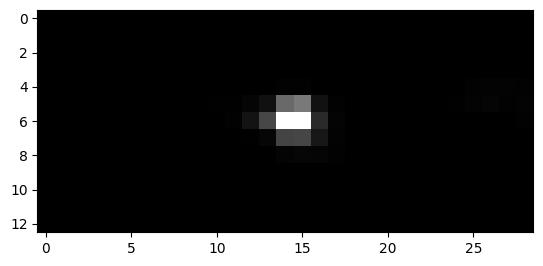

337


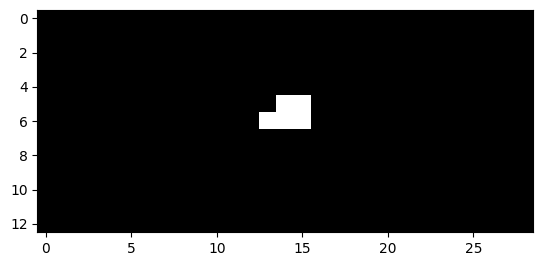

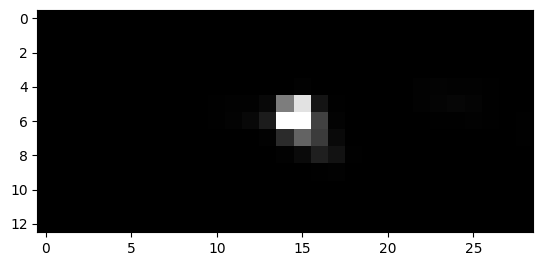

338


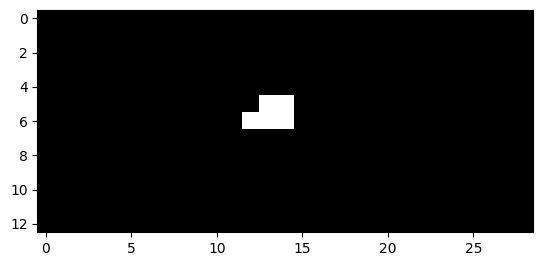

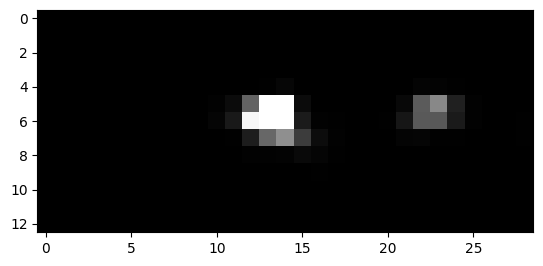

339


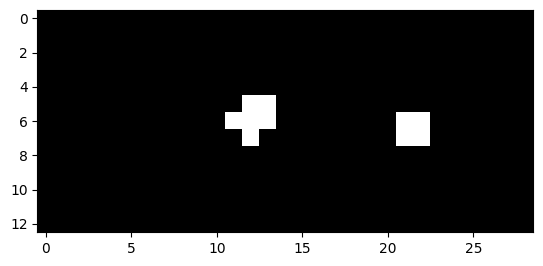

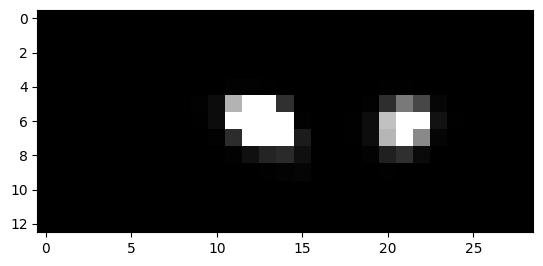

340


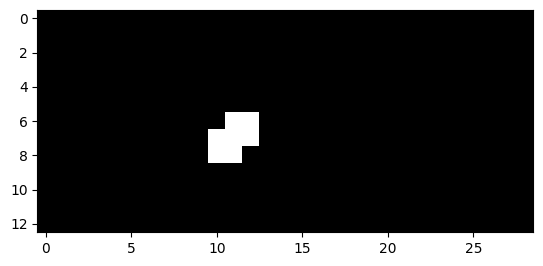

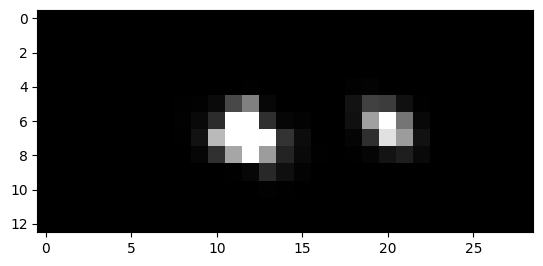

341


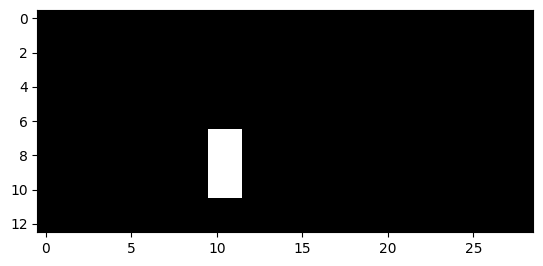

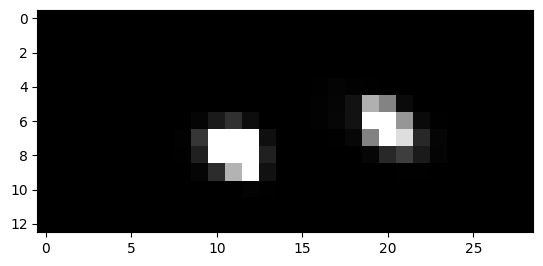

342


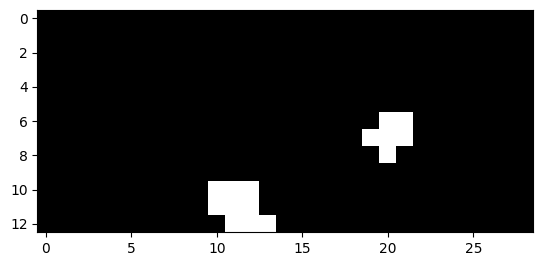

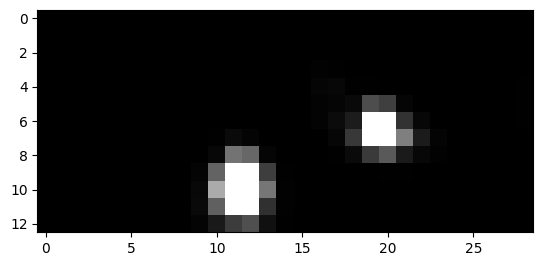

343


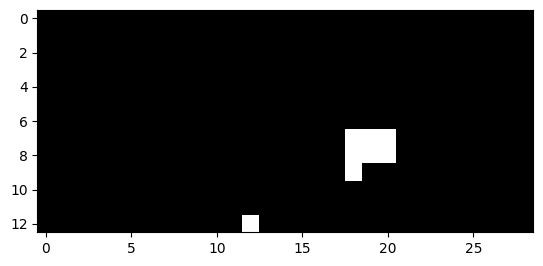

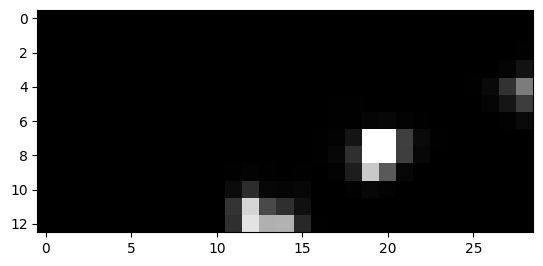

346


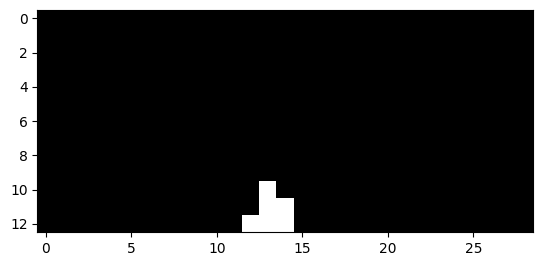

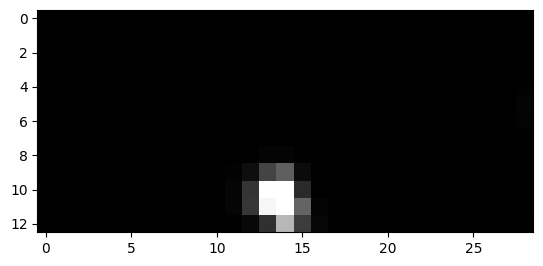

347


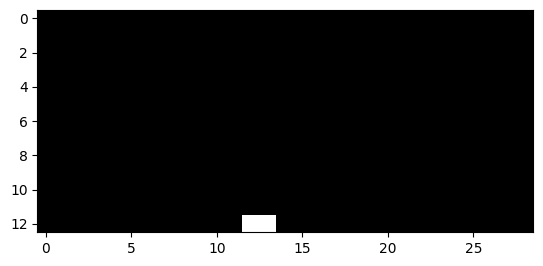

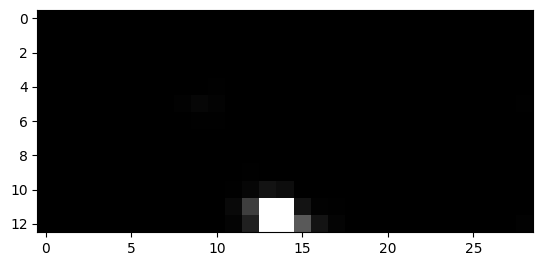

640


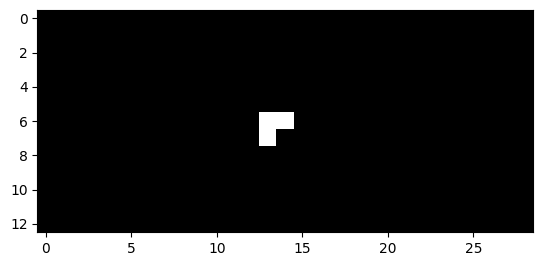

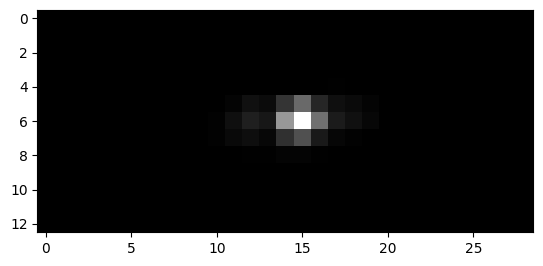

641


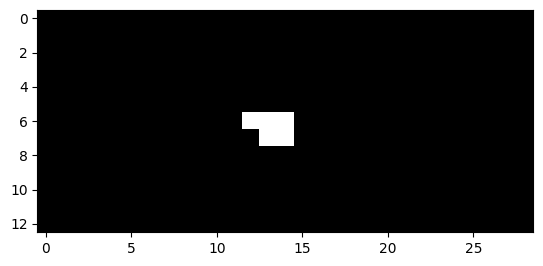

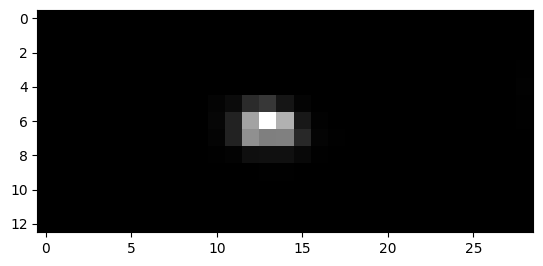

642


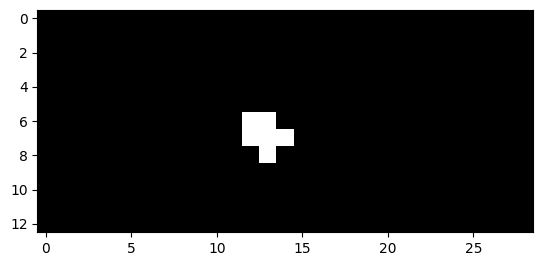

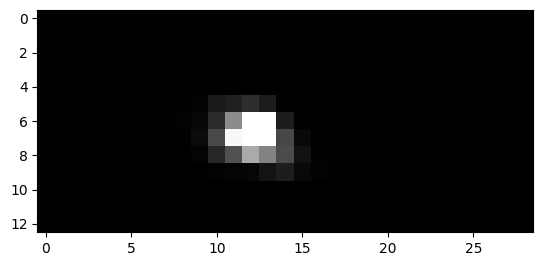

643


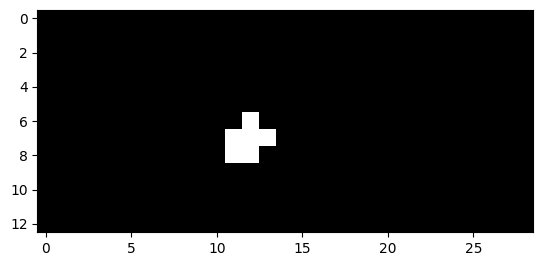

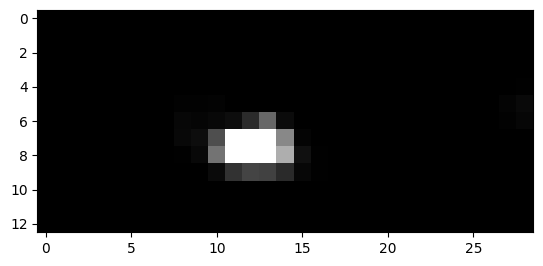

644


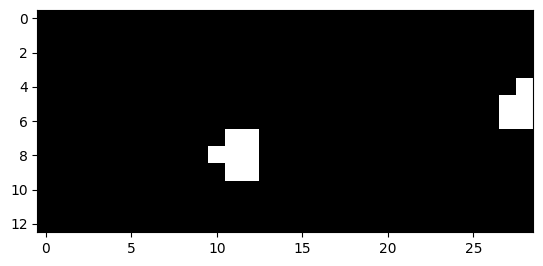

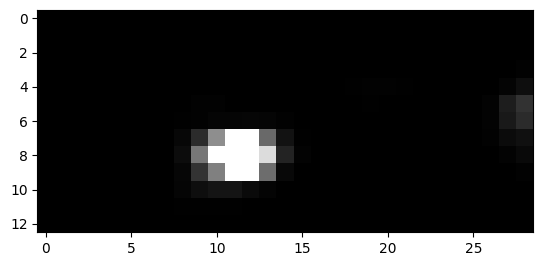

645


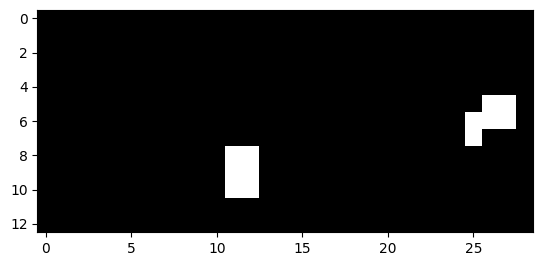

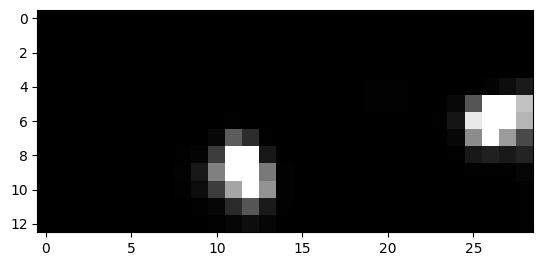

646


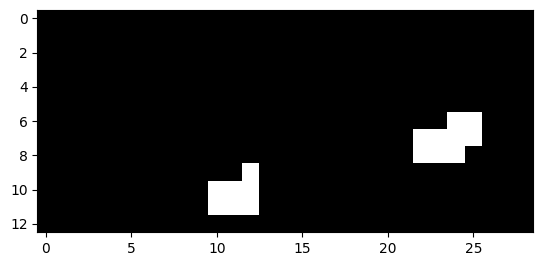

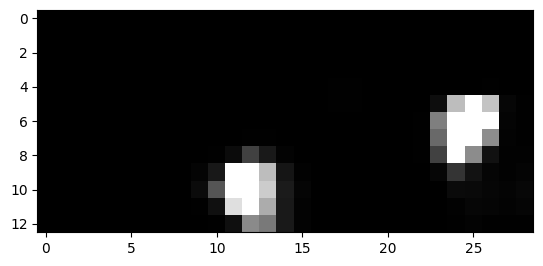

647


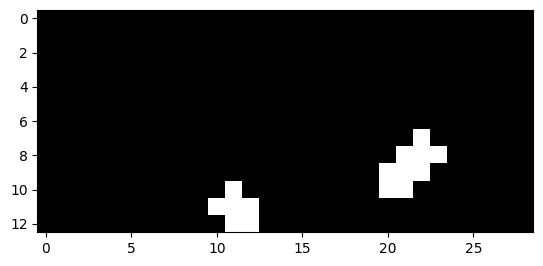

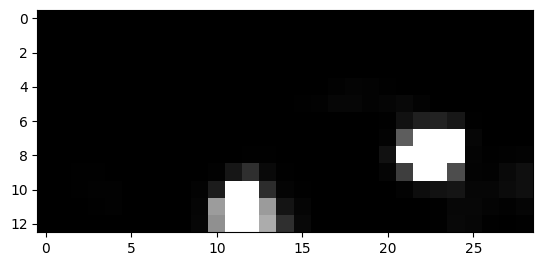

648


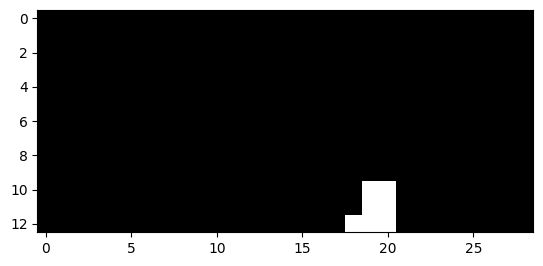

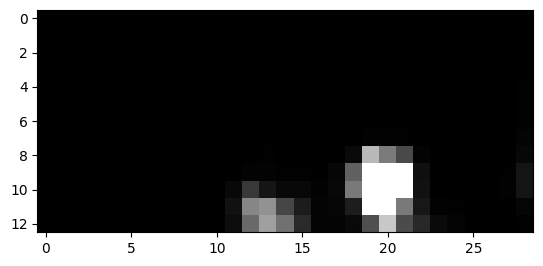

651


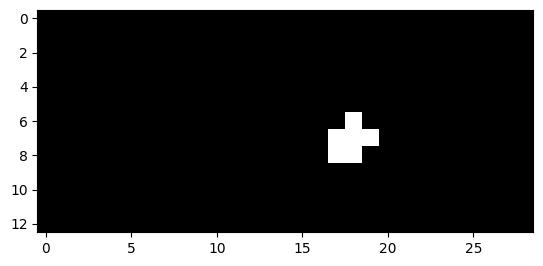

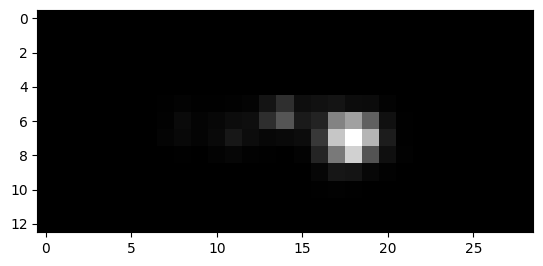

652


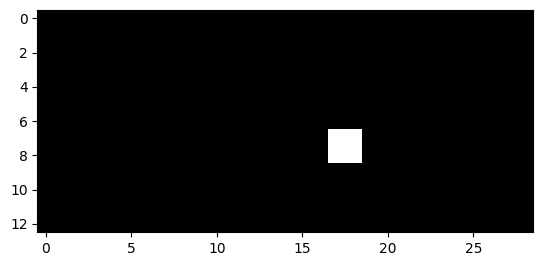

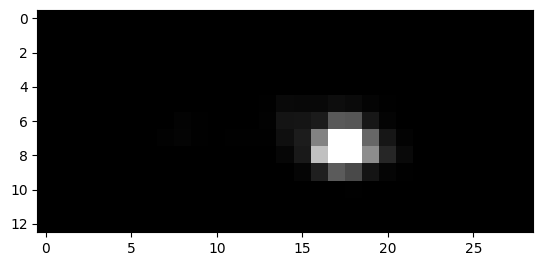

653


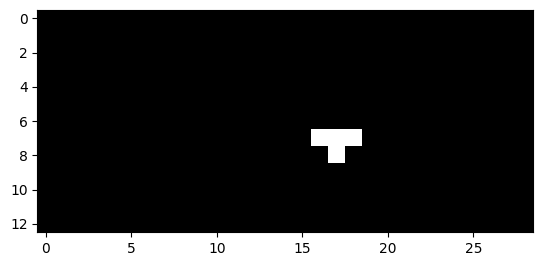

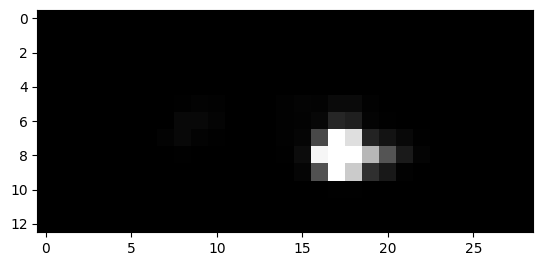

654


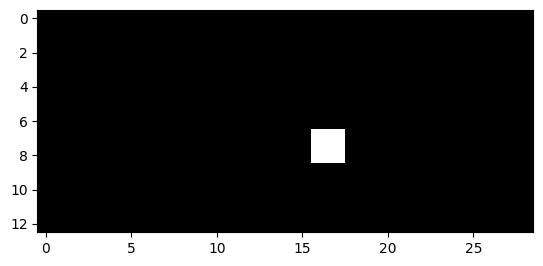

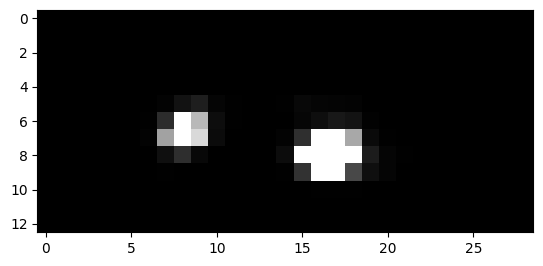

655


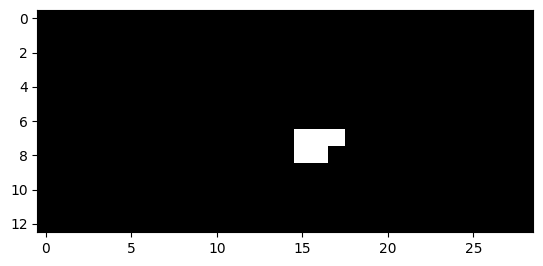

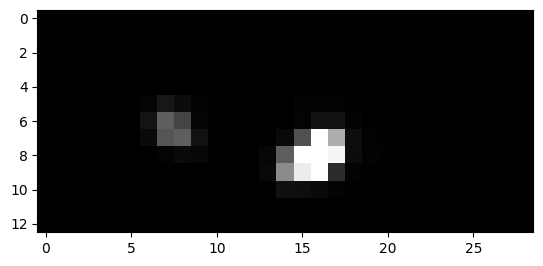

656


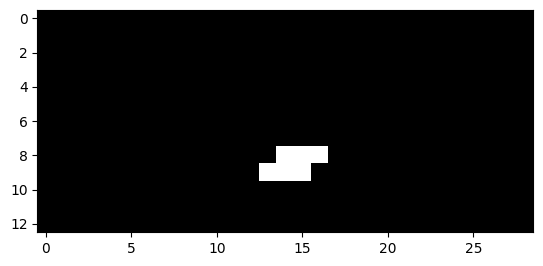

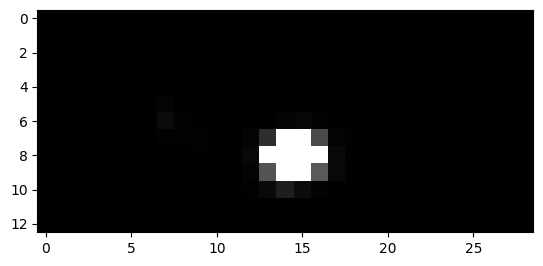

657


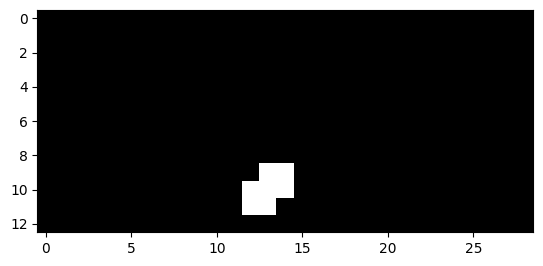

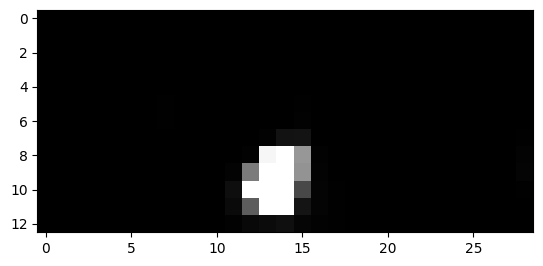

658


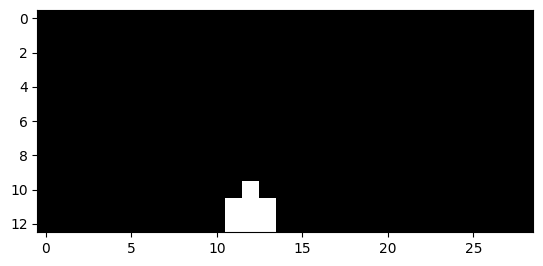

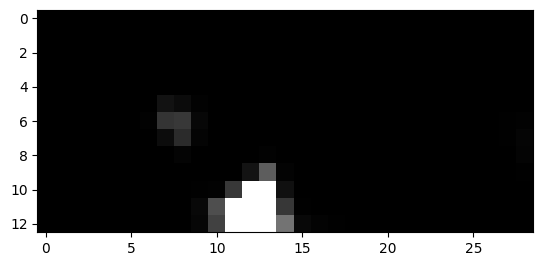

665


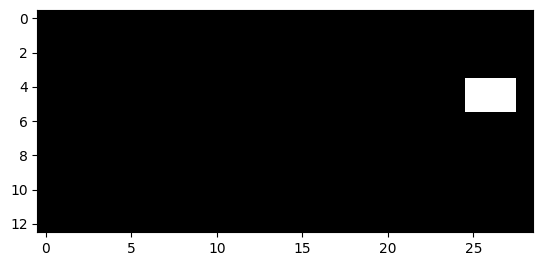

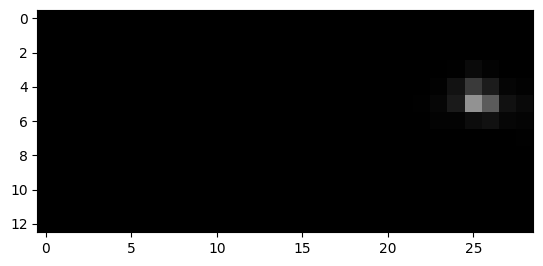

666


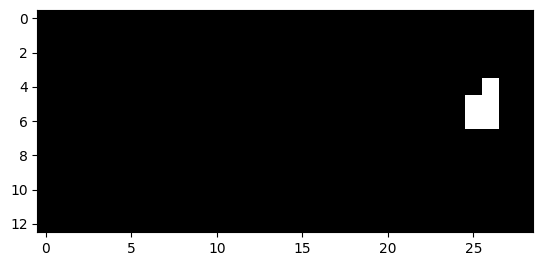

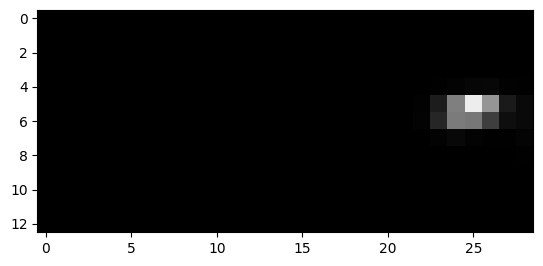

667


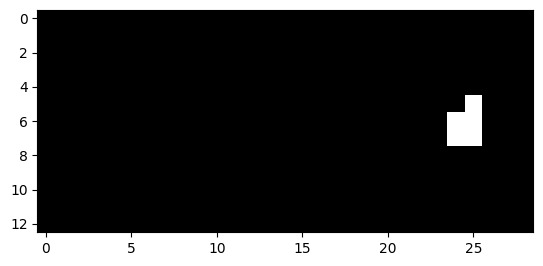

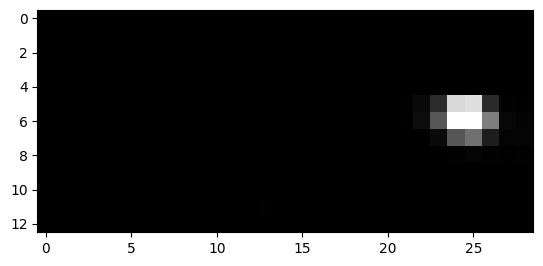

668


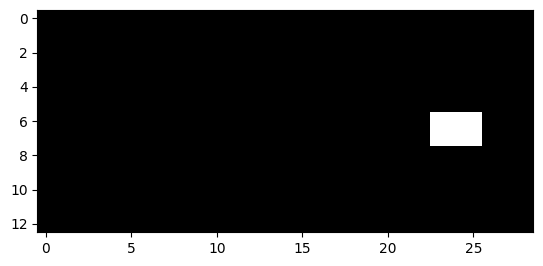

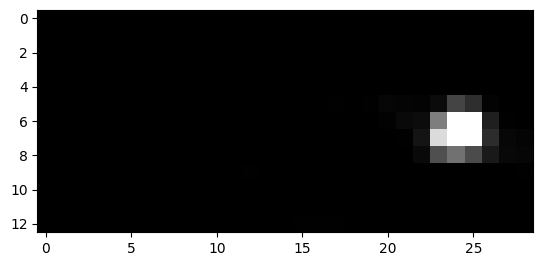

669


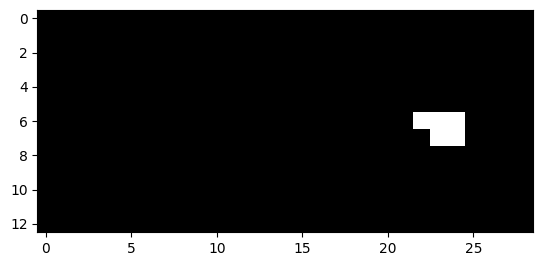

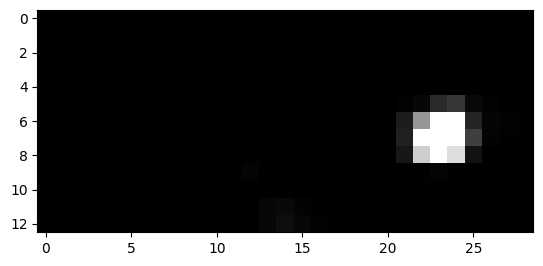

670


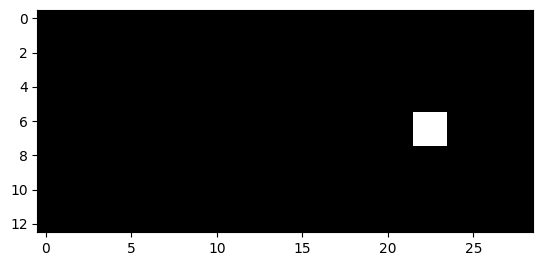

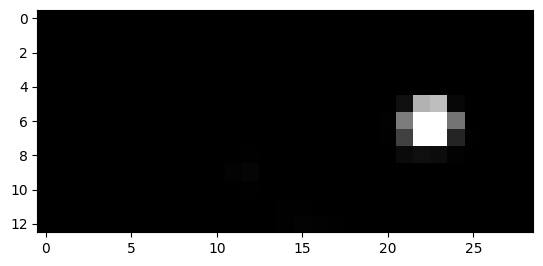

671


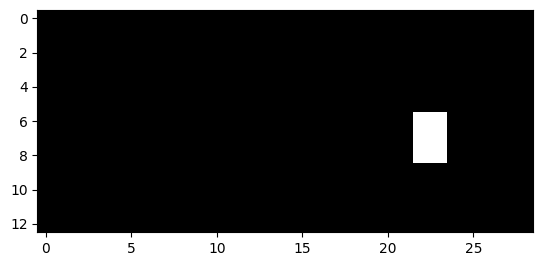

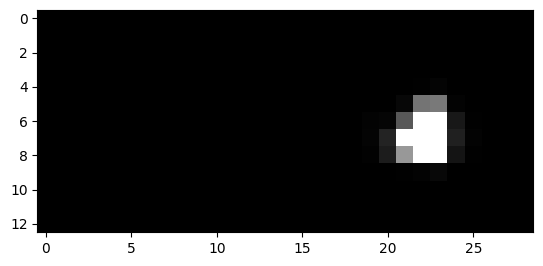

672


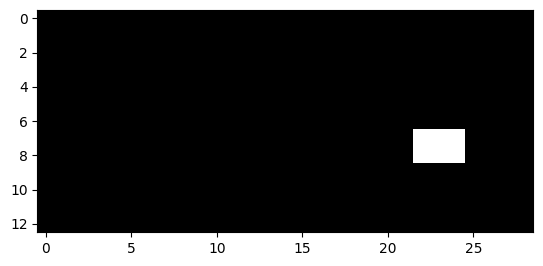

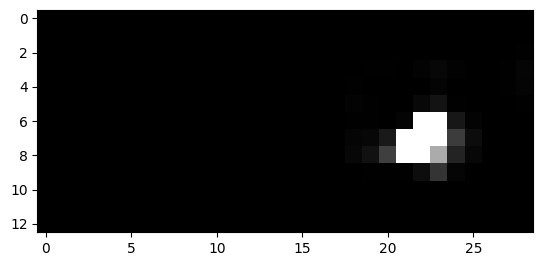

673


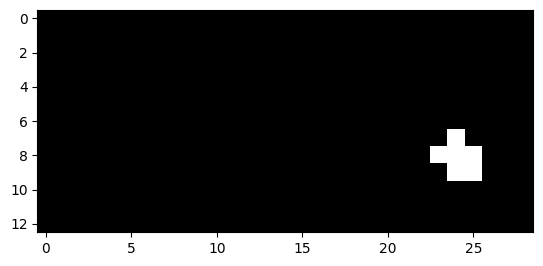

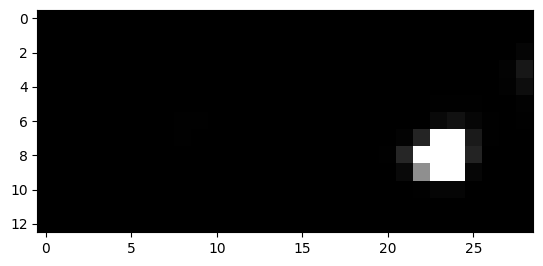

674


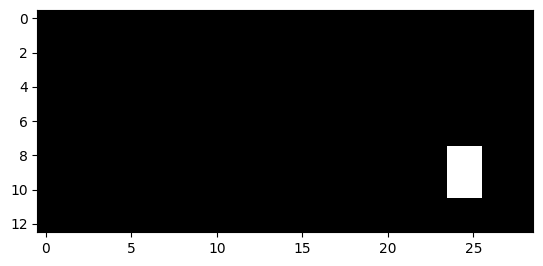

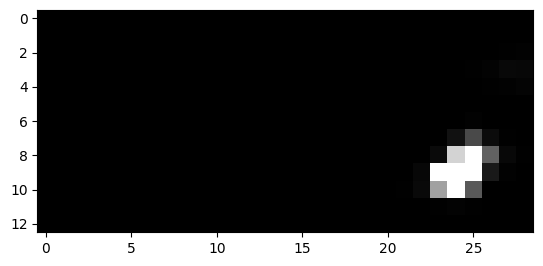

675


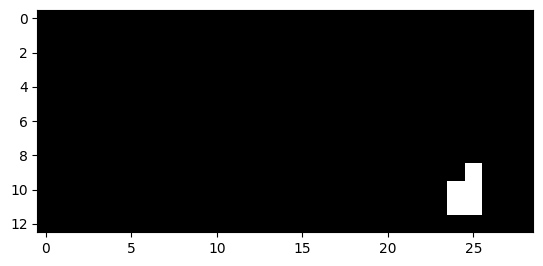

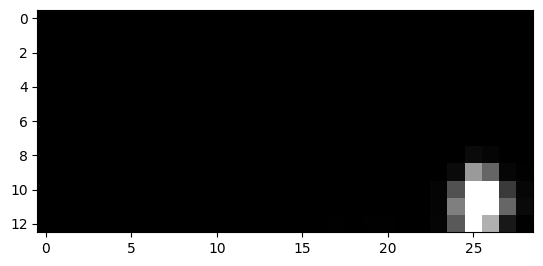

676


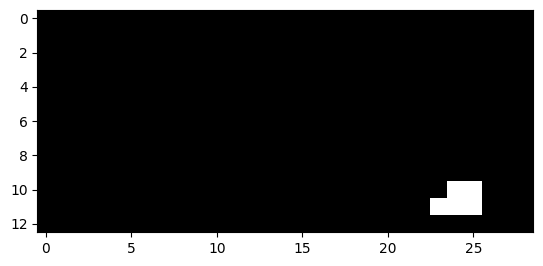

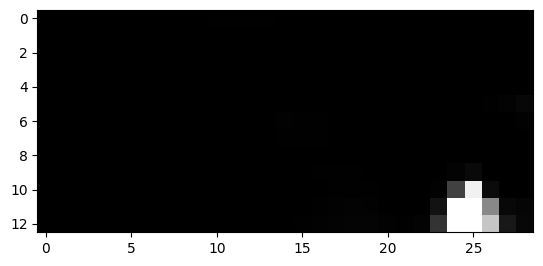

677


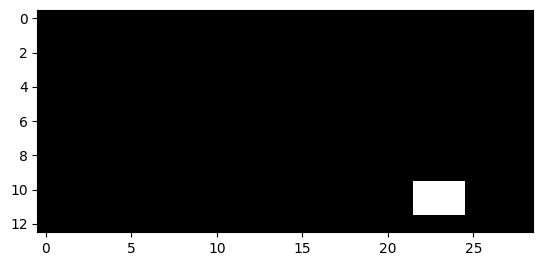

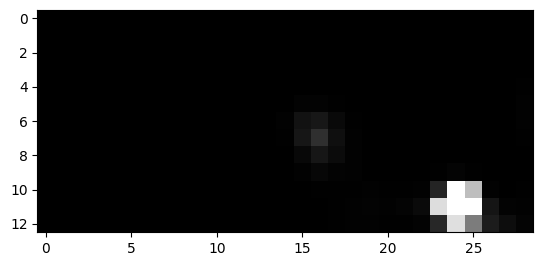

700


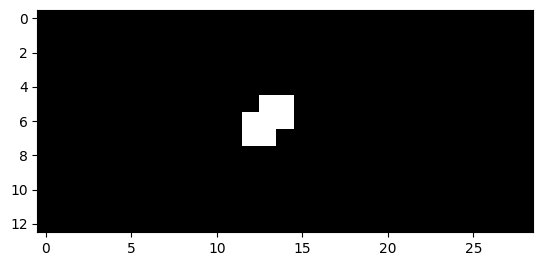

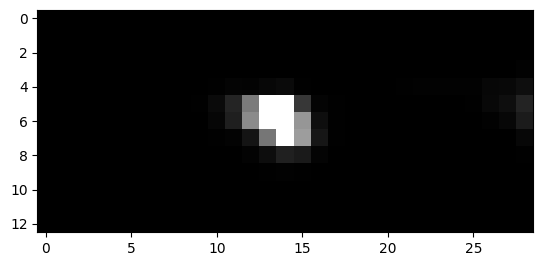

701


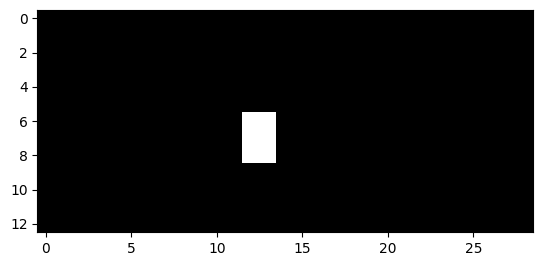

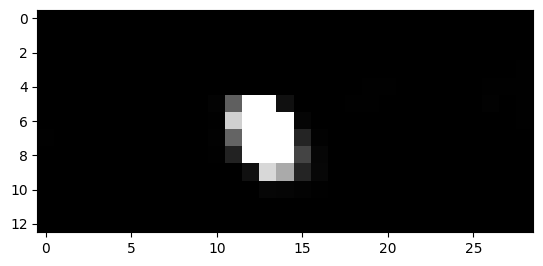

702


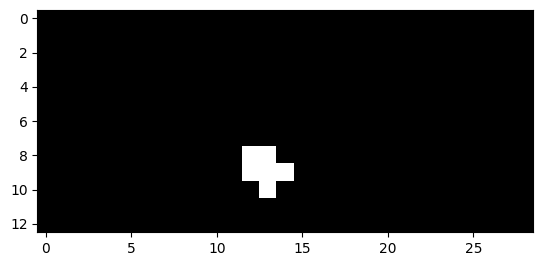

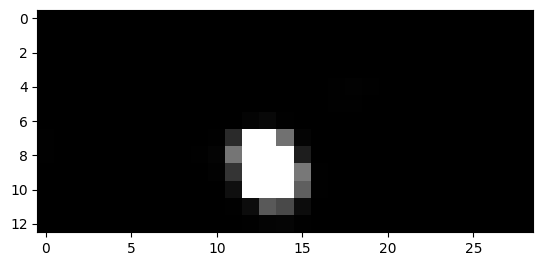

703


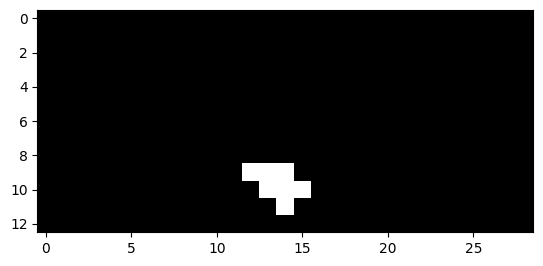

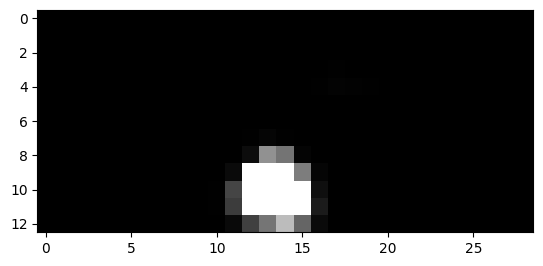

704


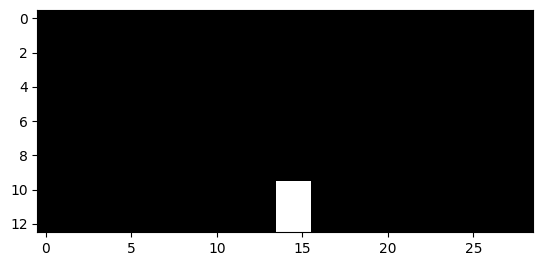

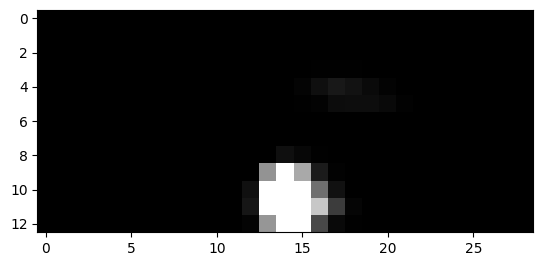

705


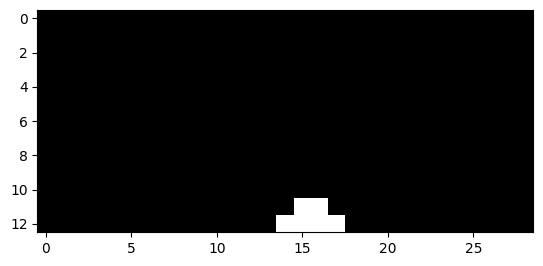

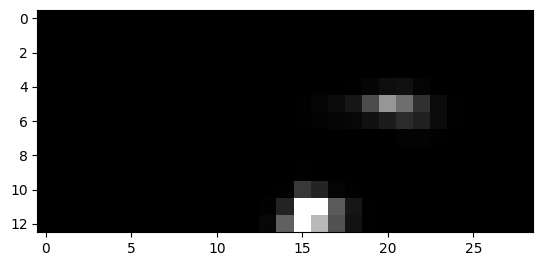

711


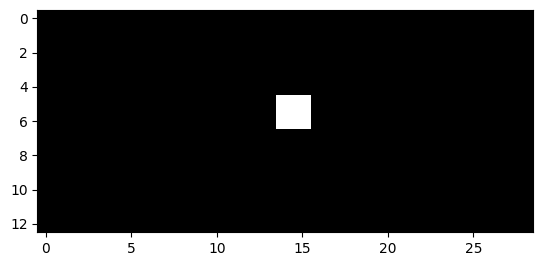

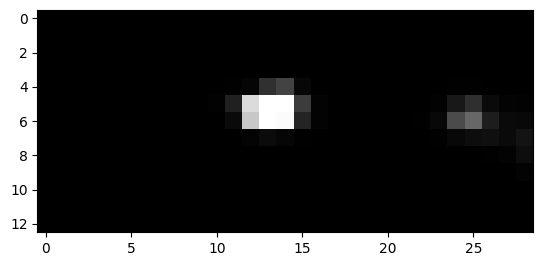

712


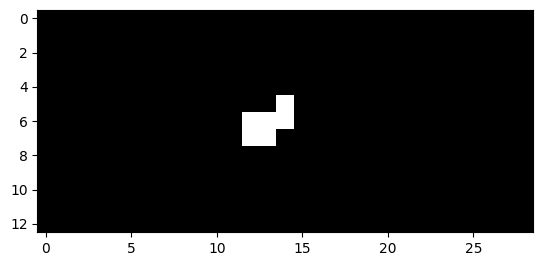

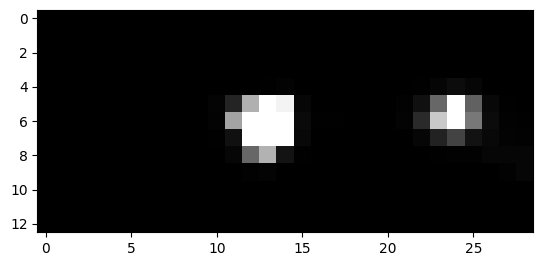

713


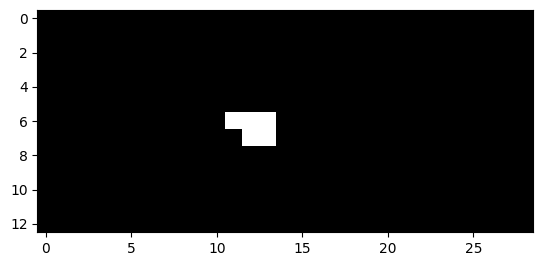

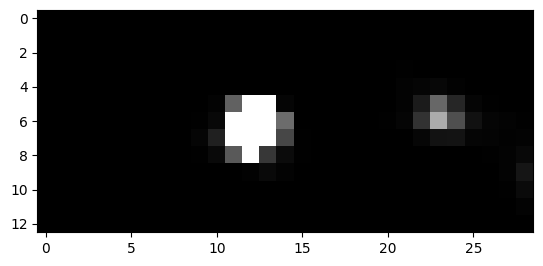

714


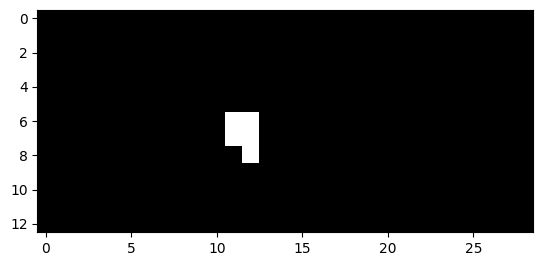

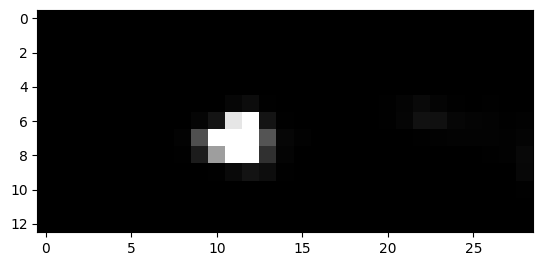

715


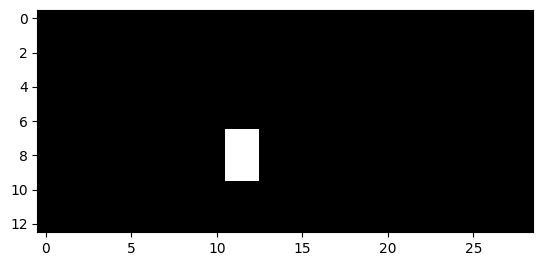

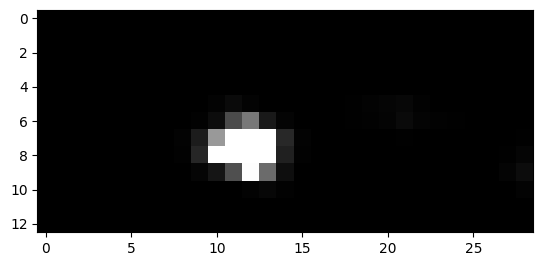

716


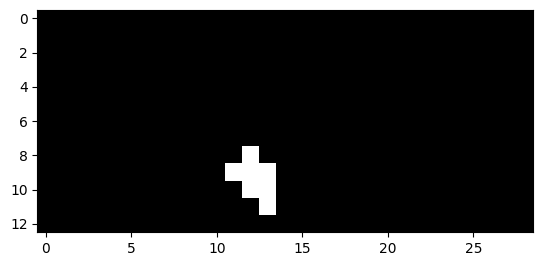

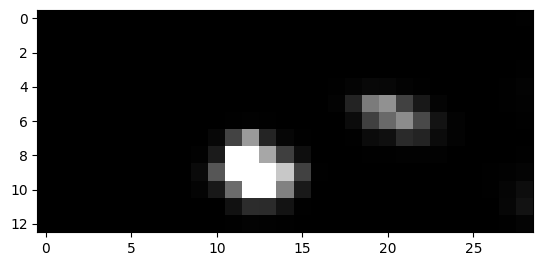

717


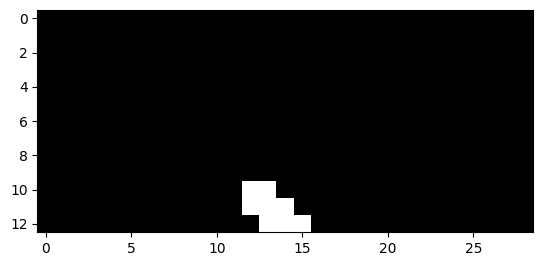

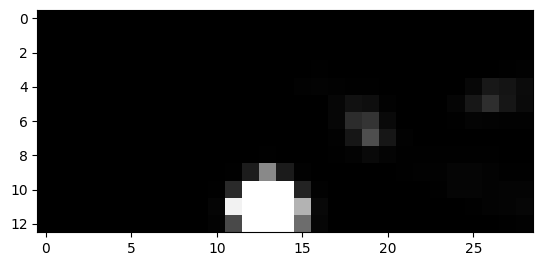

718


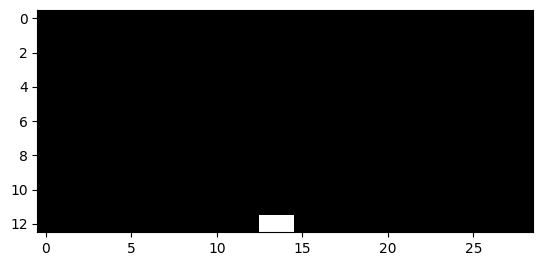

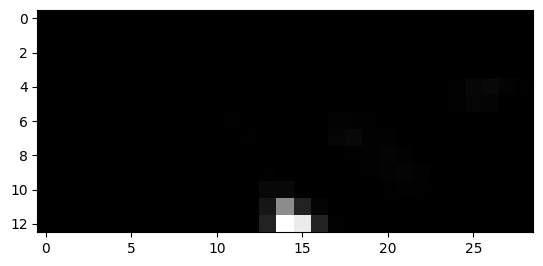

751


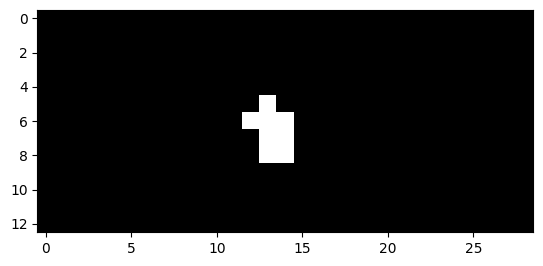

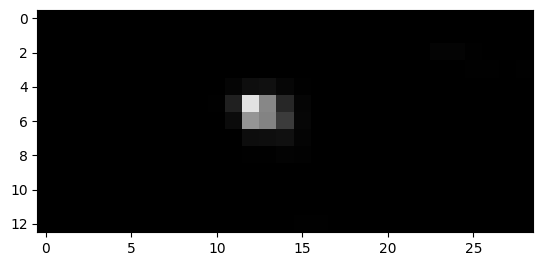

752


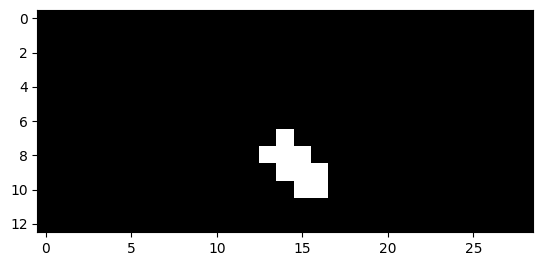

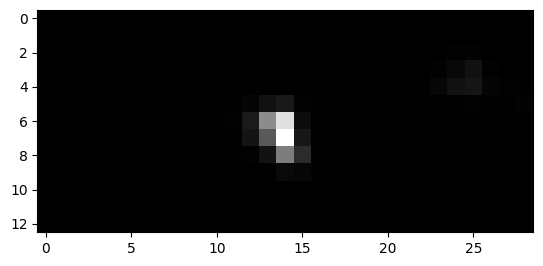

753


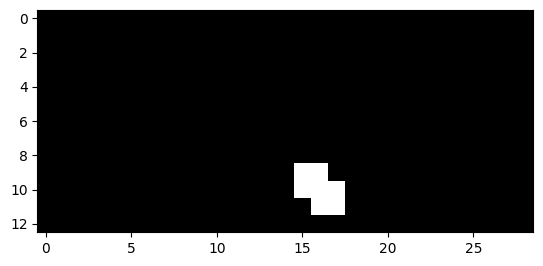

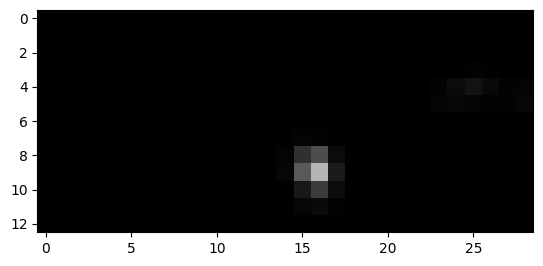

754


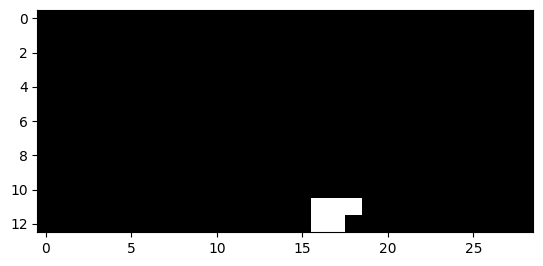

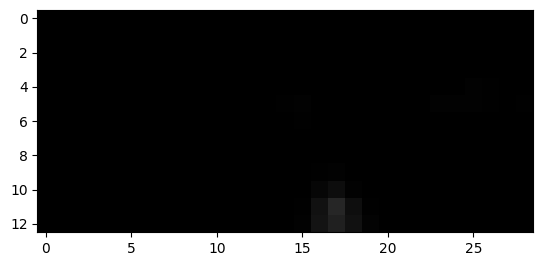

756


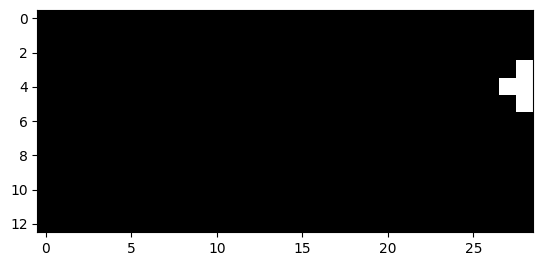

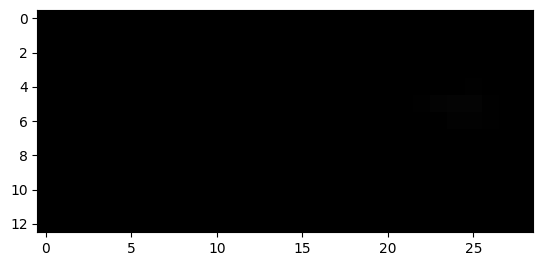

757


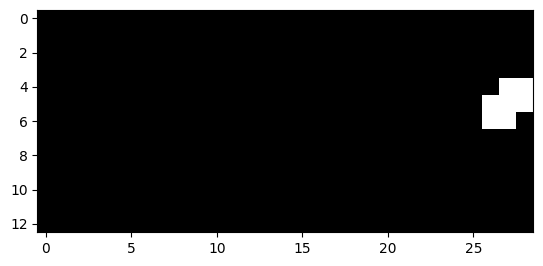

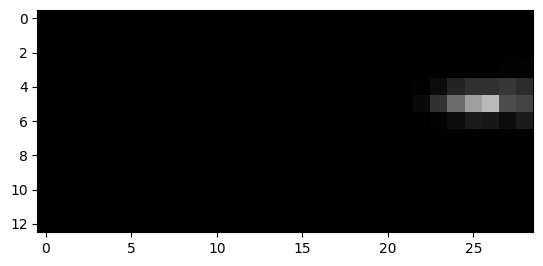

758


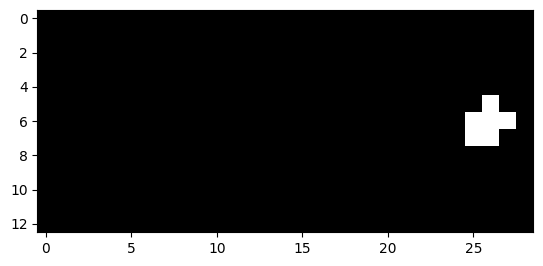

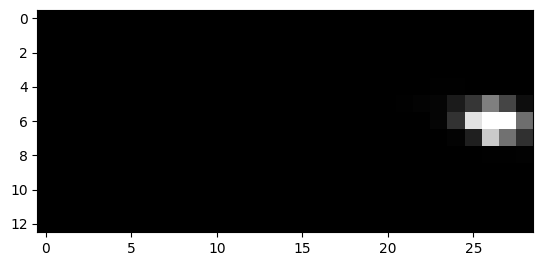

759


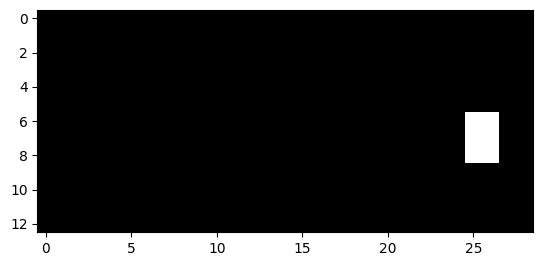

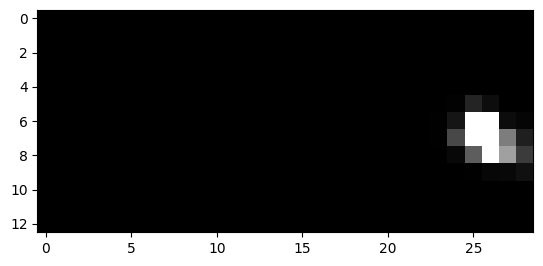

760


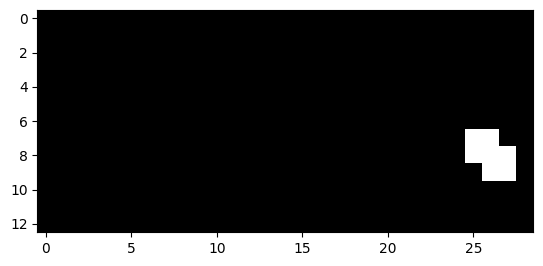

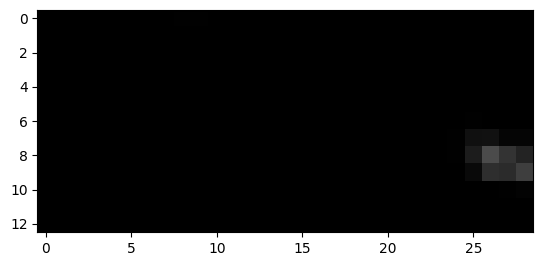

761


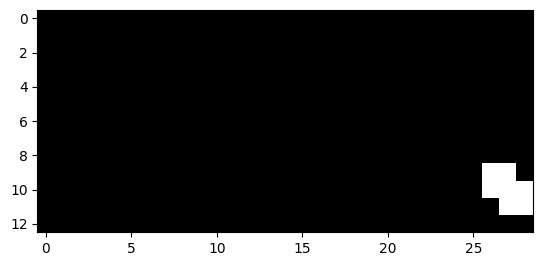

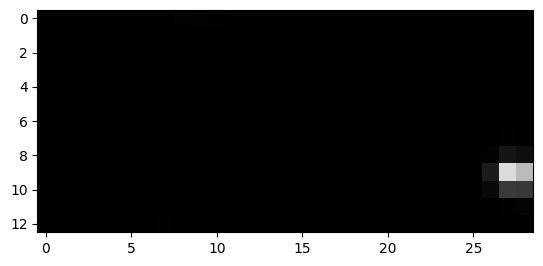

762


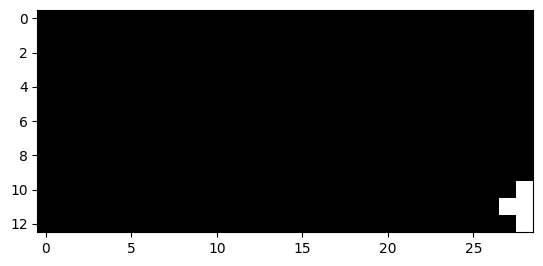

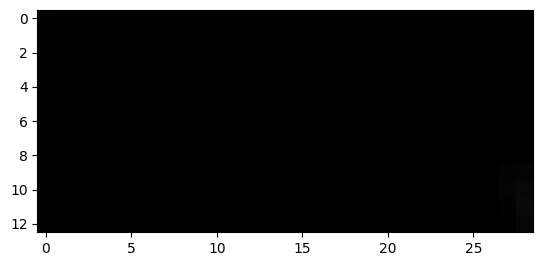

1023


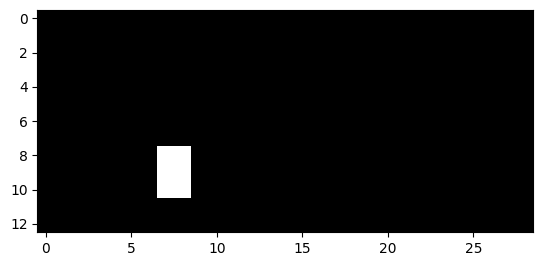

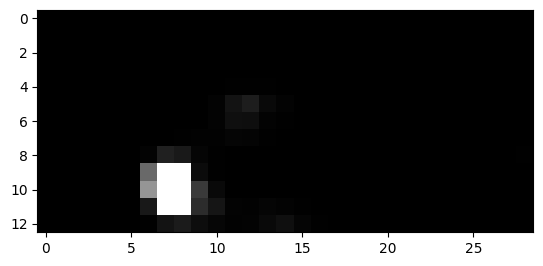

1024


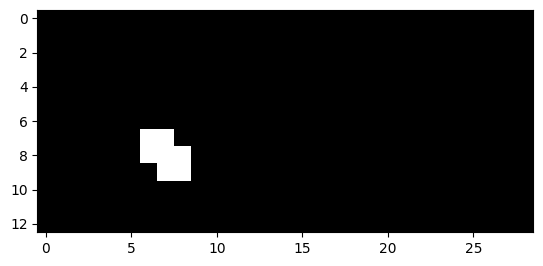

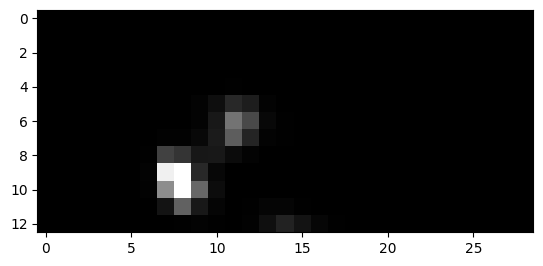

1039


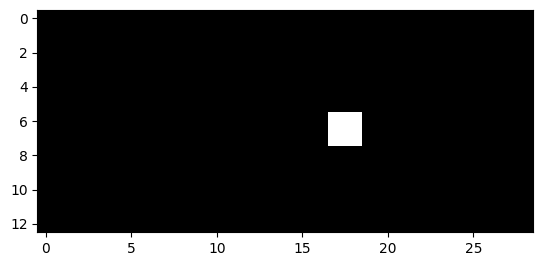

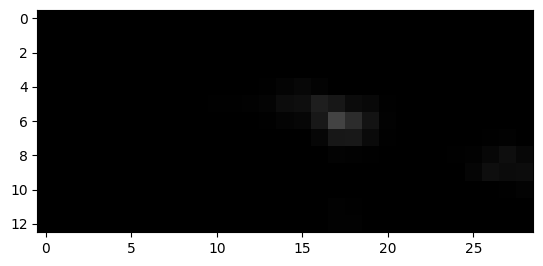

1040


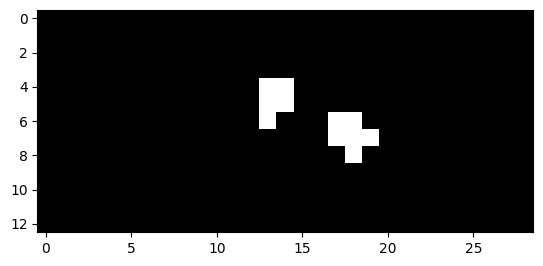

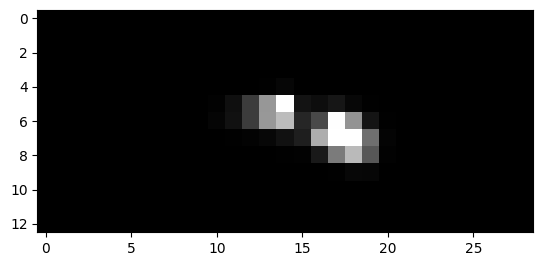

1041


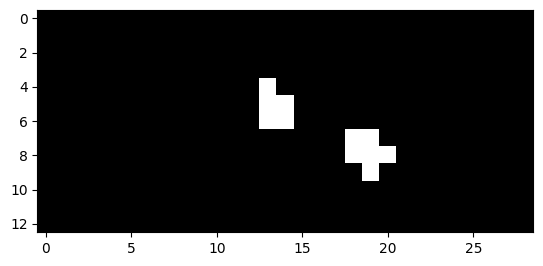

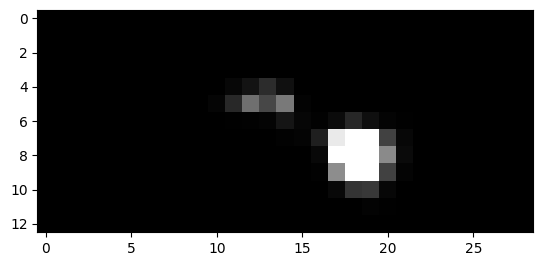

1042


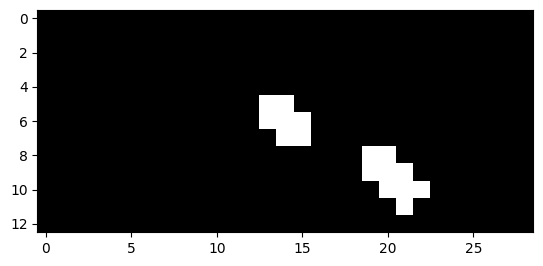

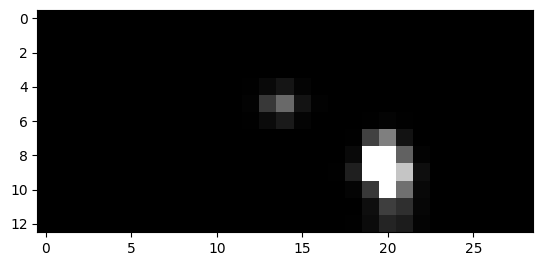

1043


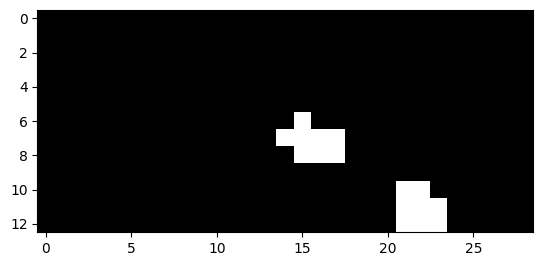

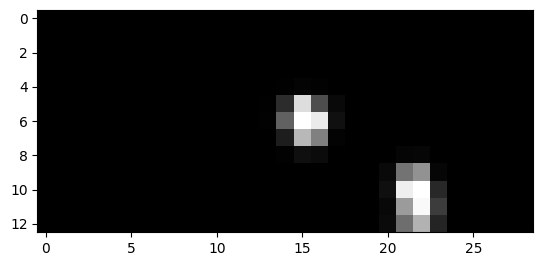

1044


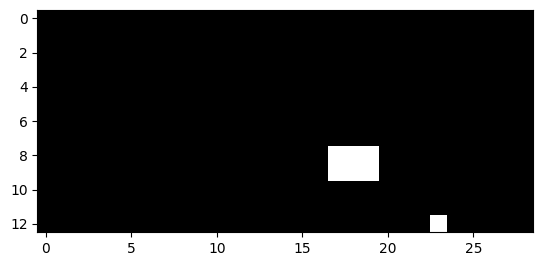

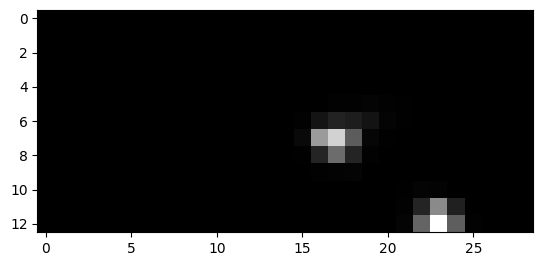

1045


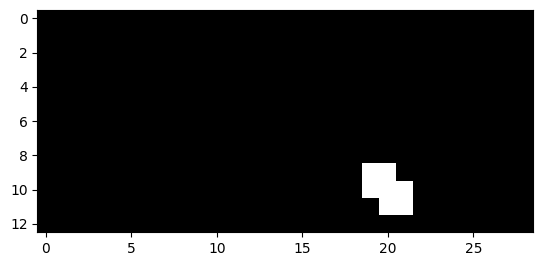

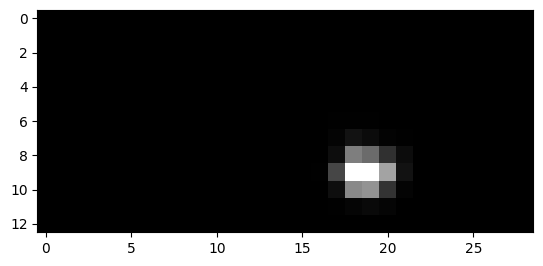

1046


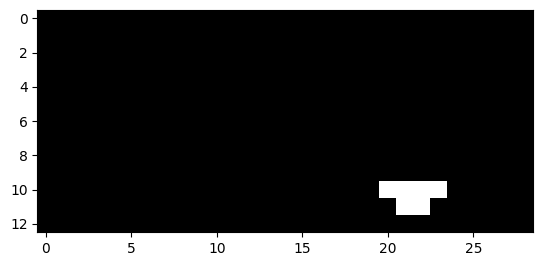

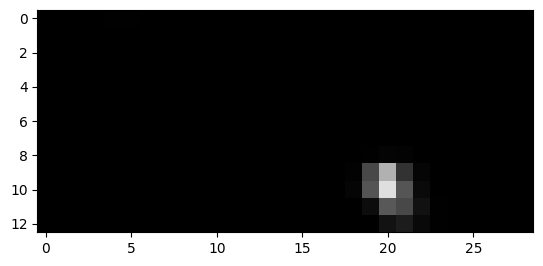

1047


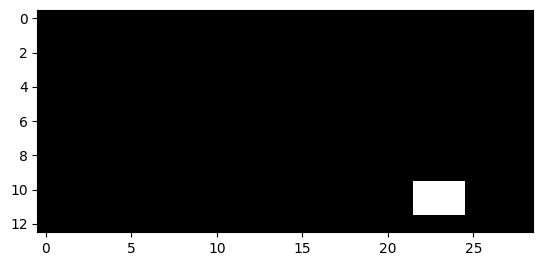

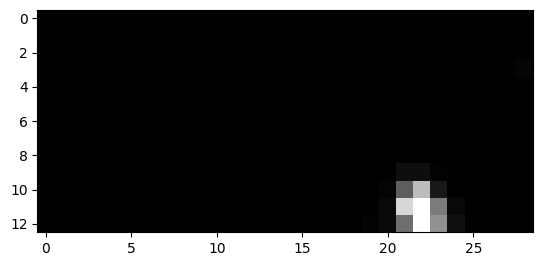

1048


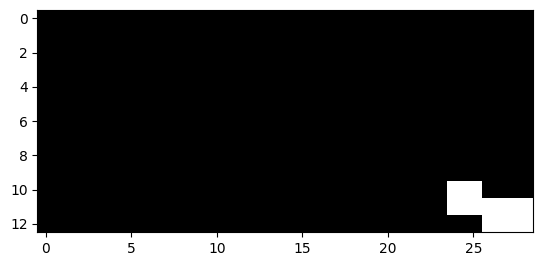

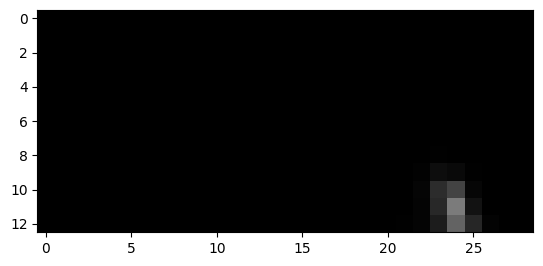

1049


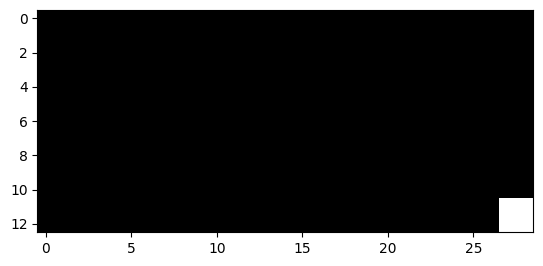

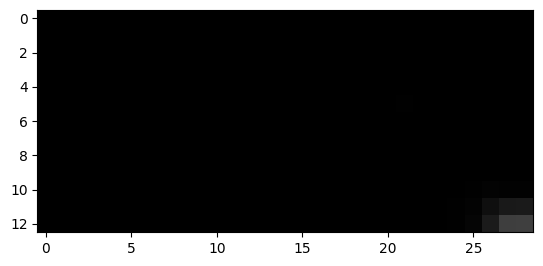

1064


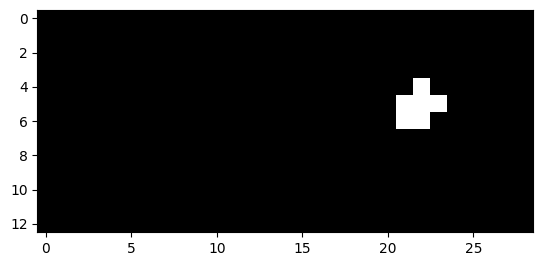

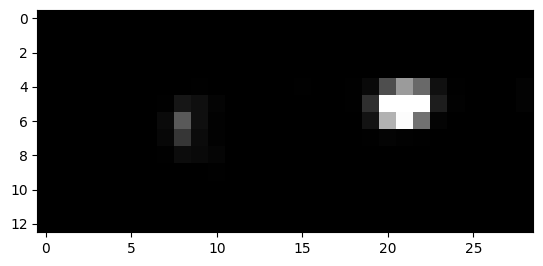

1065


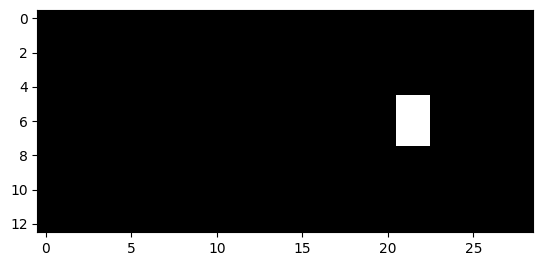

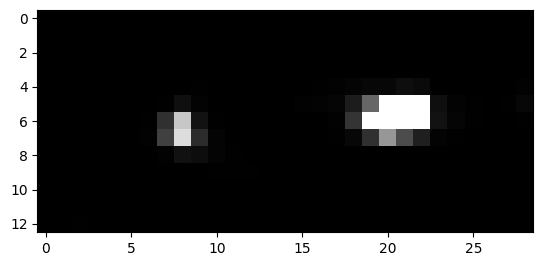

1066


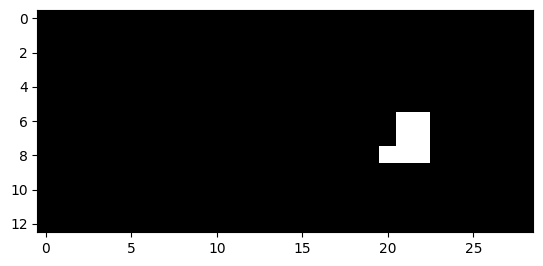

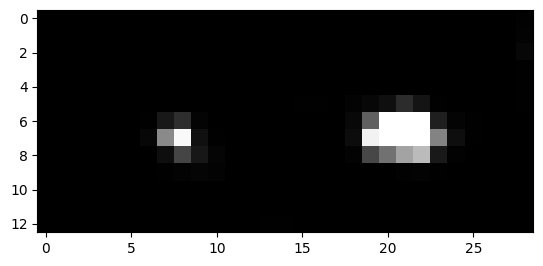

1067


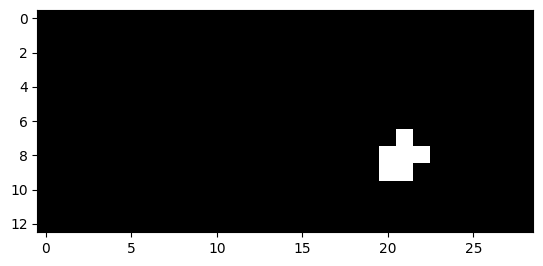

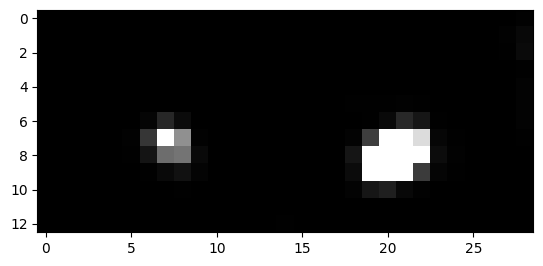

1068


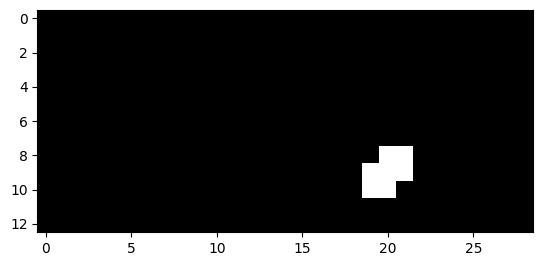

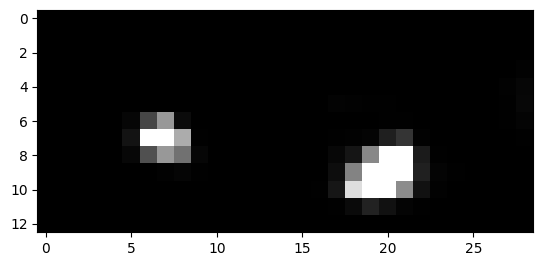

1069


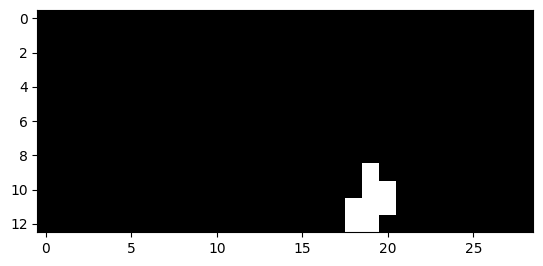

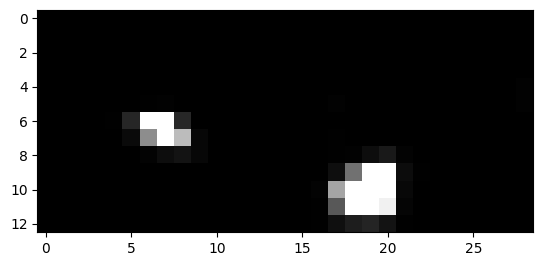

1070


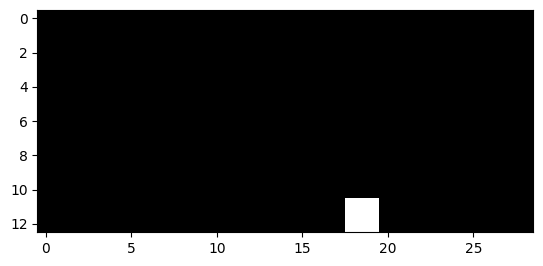

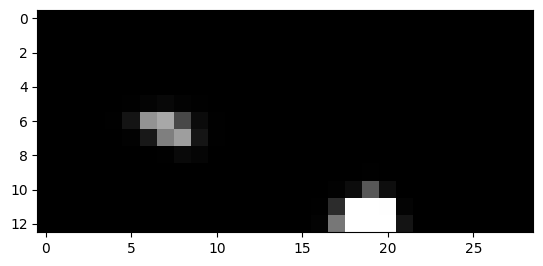

1071


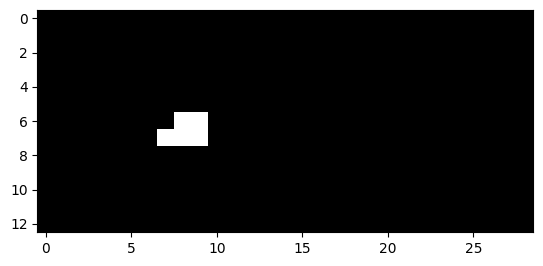

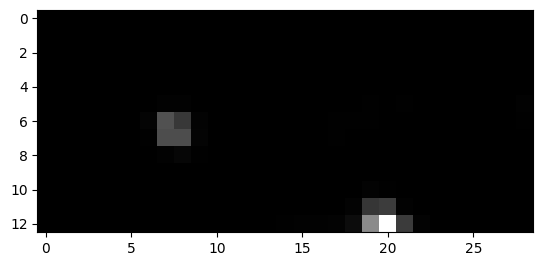

1072


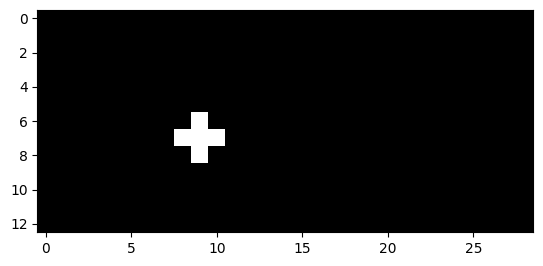

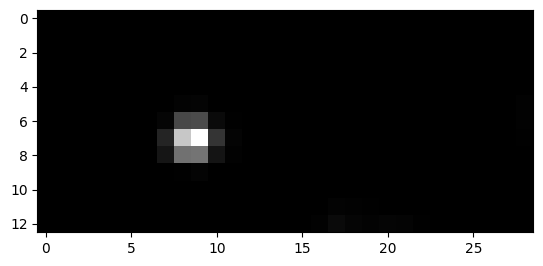

1073


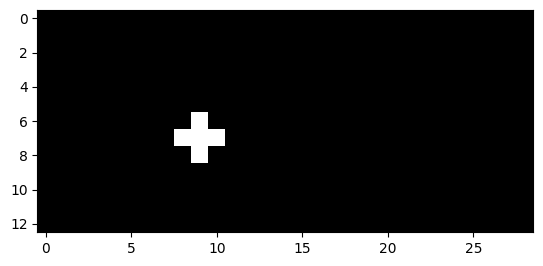

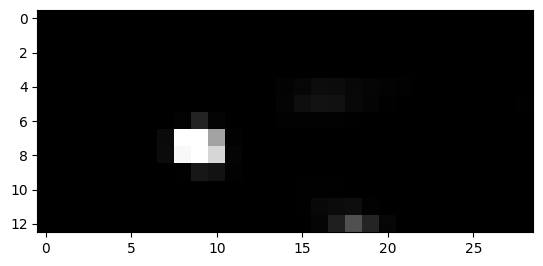

1074


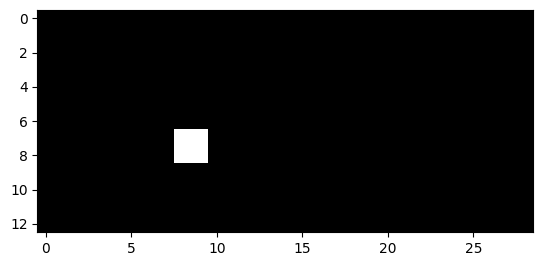

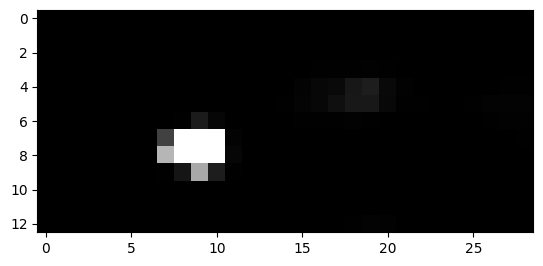

1075


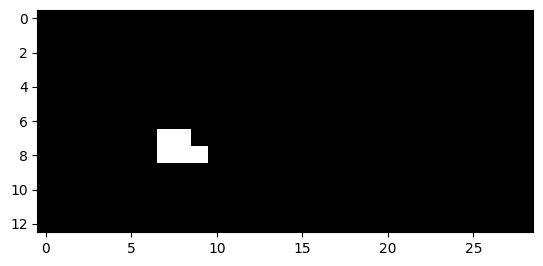

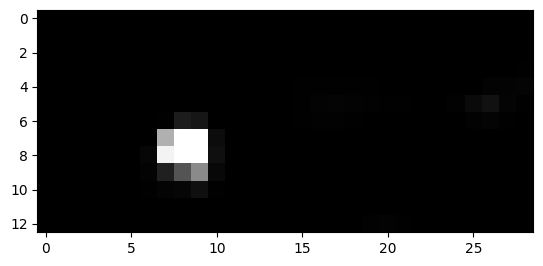

1076


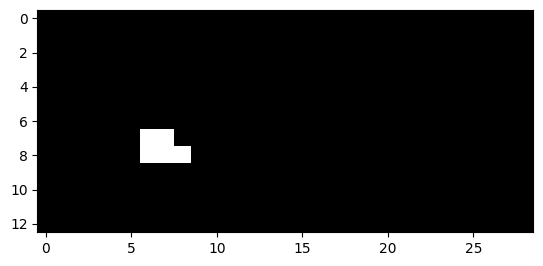

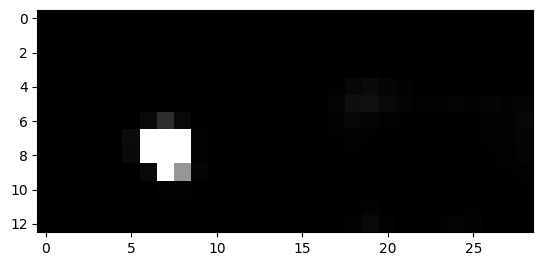

1078


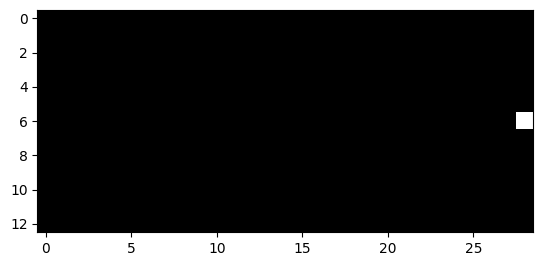

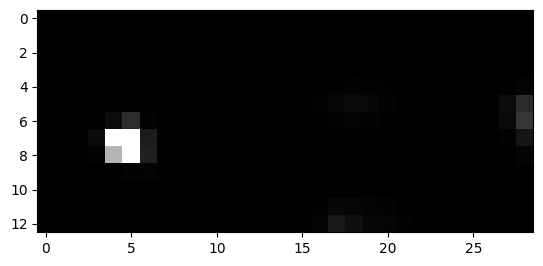

1079


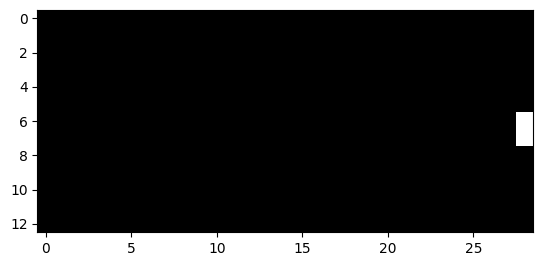

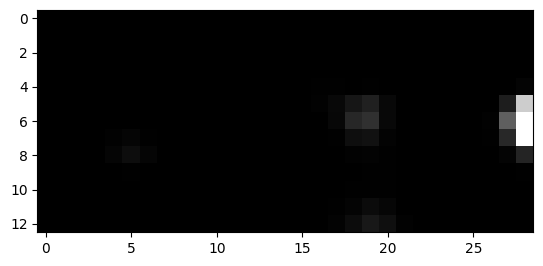

1080


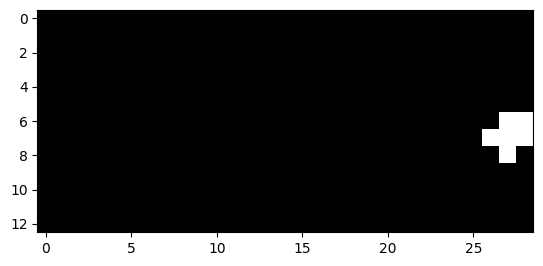

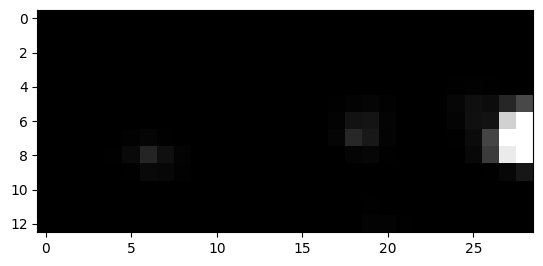

1081


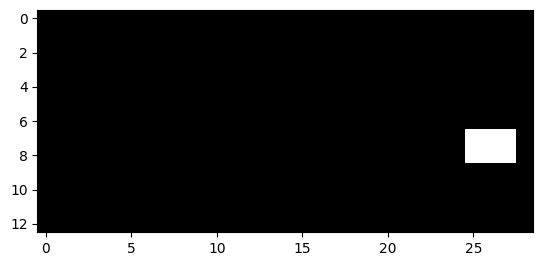

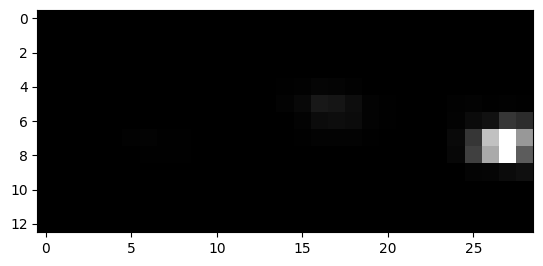

1082


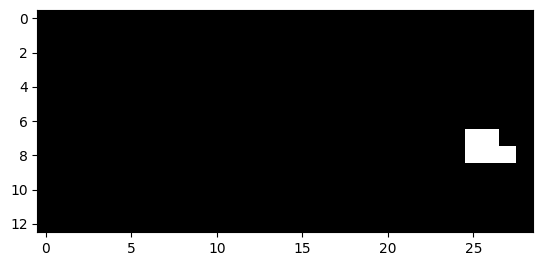

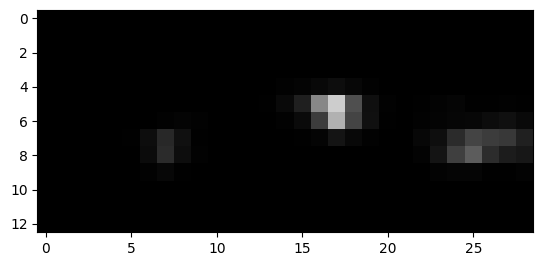

1083


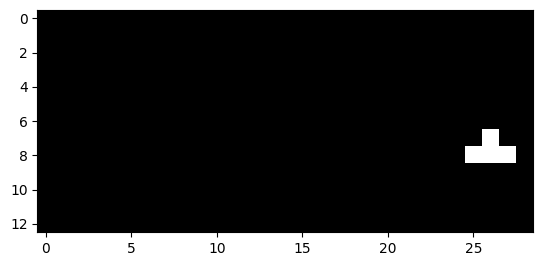

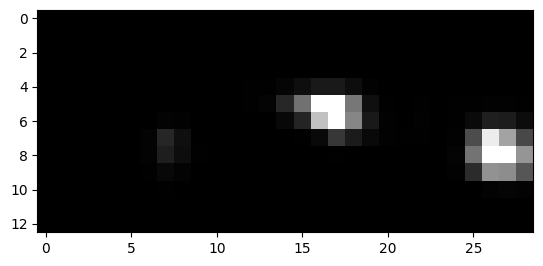

1084


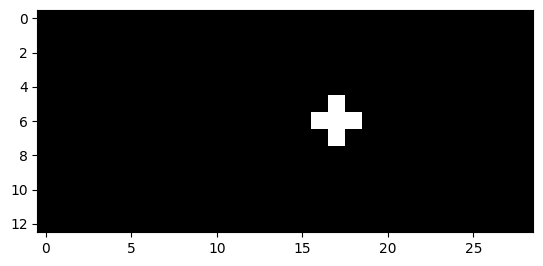

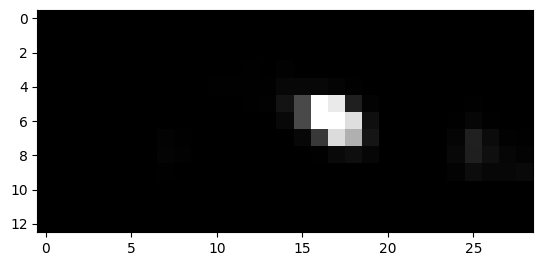

1085


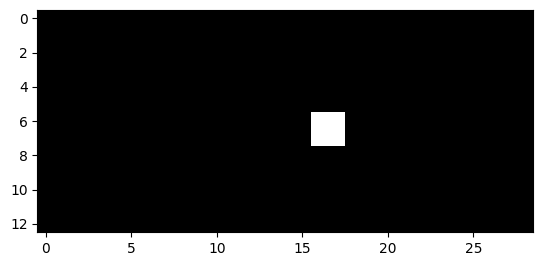

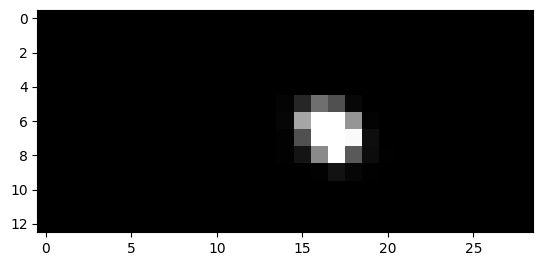

1086


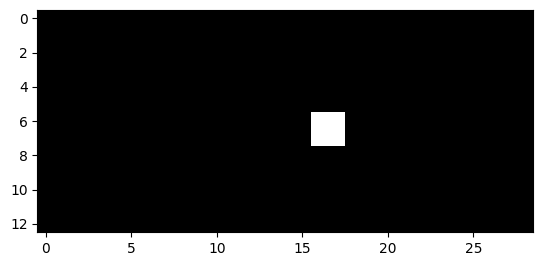

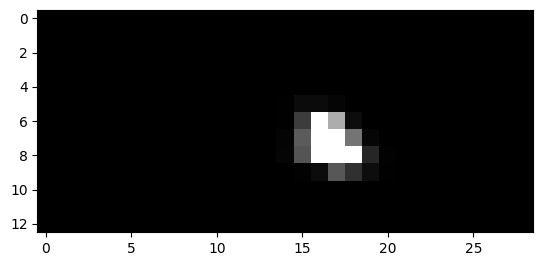

1087


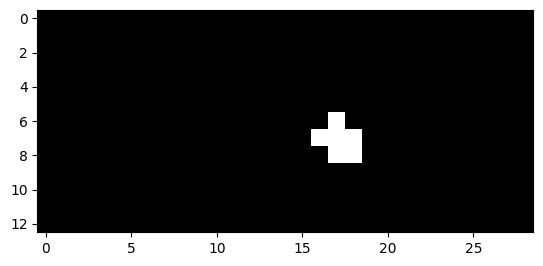

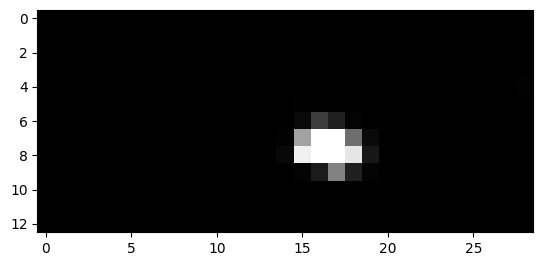

1088


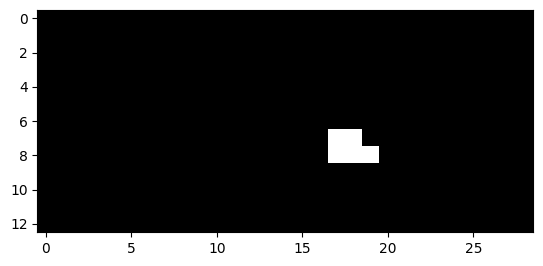

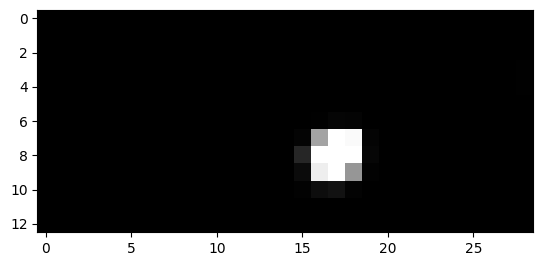

1089


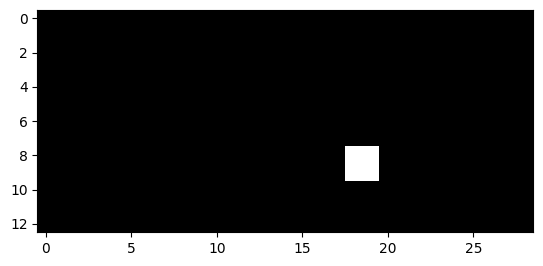

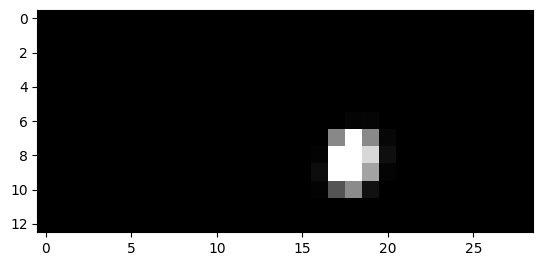

1090


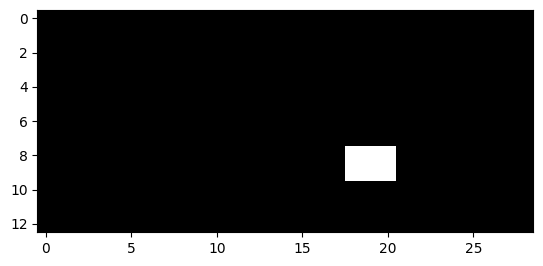

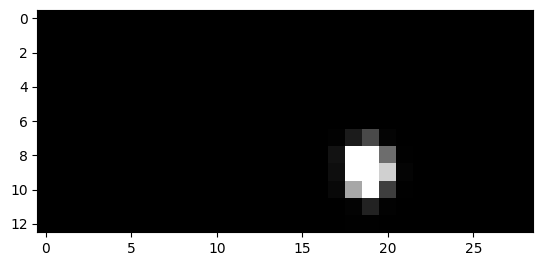

1091


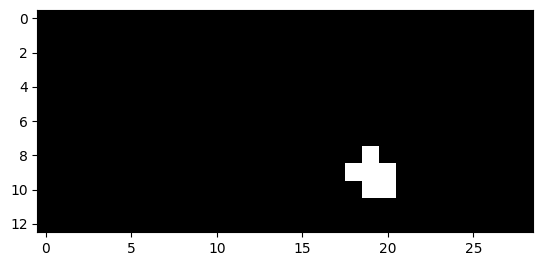

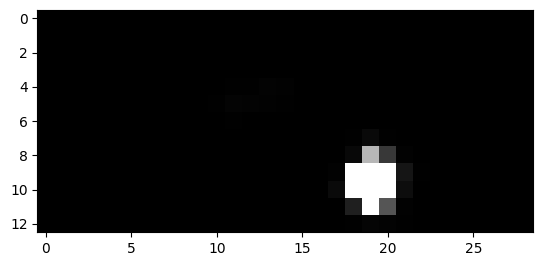

1092


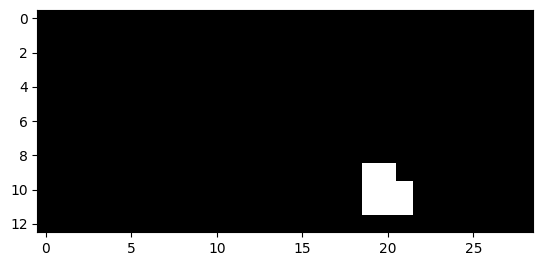

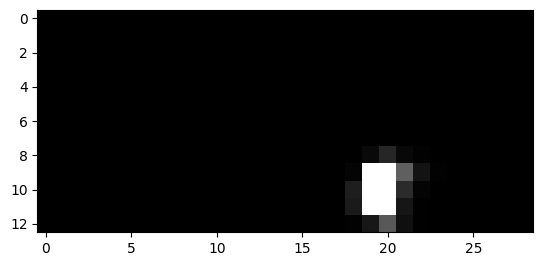

1093


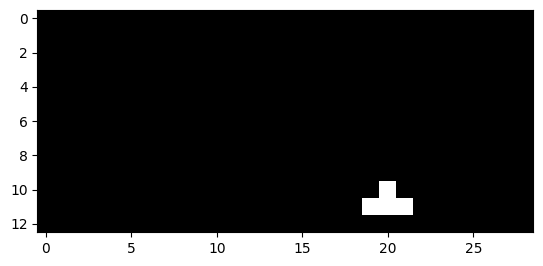

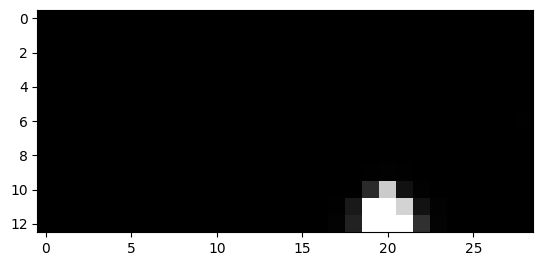

1116


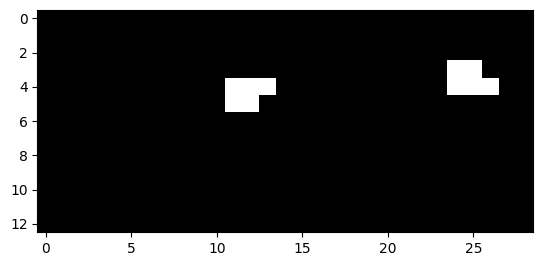

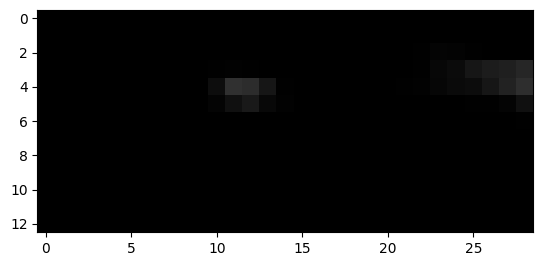

1117


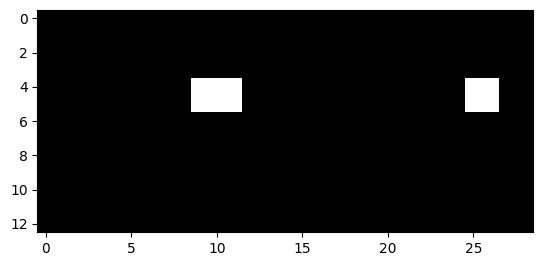

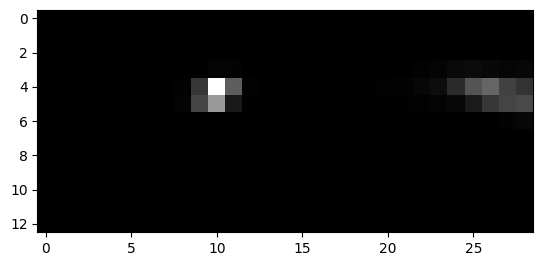

1118


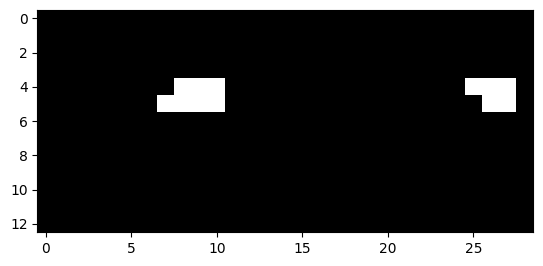

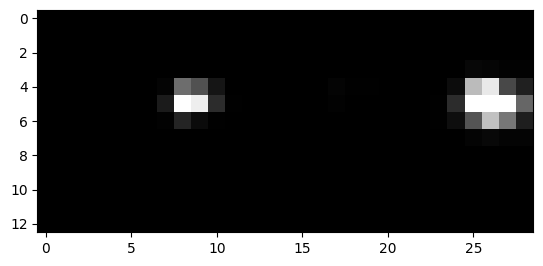

1119


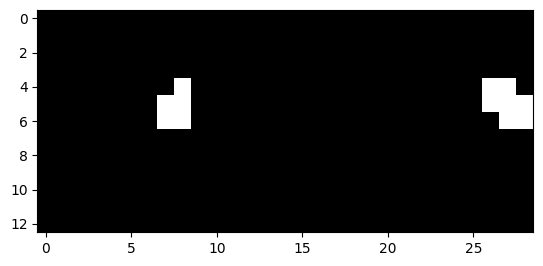

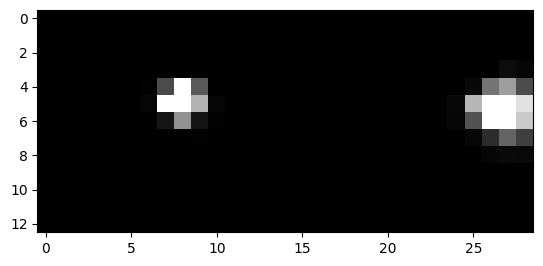

1120


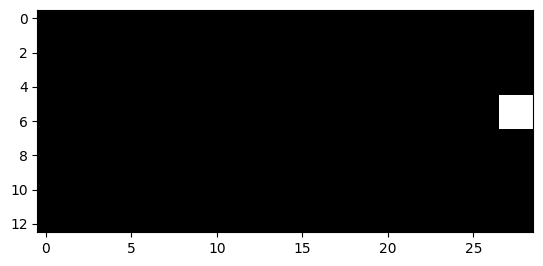

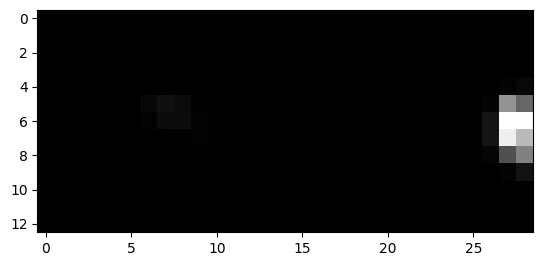

1121


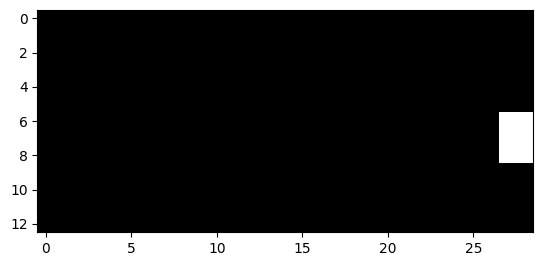

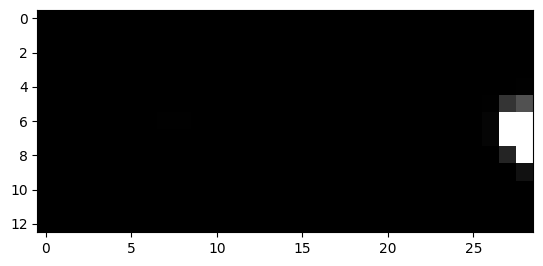

1122


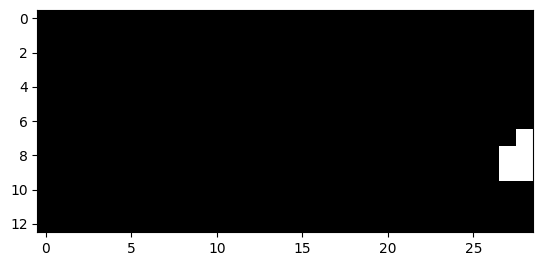

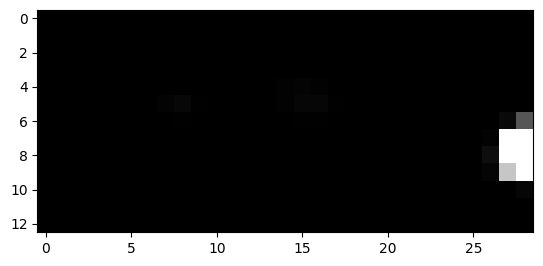

141


In [14]:
k=0
for i in range(len(y_test_img_old)): 
    if(np.max(y_test_img_old[i].reshape(-1))>0.1):
        print(i)
        plt.figure()
        plt.imshow(y_test_img_old[i], cmap = "gray", vmin=0, vmax=1)
        plt.show()
        plt.imshow(t[i], vmin=0, vmax=0.3, cmap = "gray")
        plt.show()
        k+=1
print(k)

## old target, 0 - 48 hours

In [15]:
y_test_img_old_24_48 = np.zeros(y_test_img_old.shape)
for i in range(y_test_img_old.shape[0]-1):
    y_test_img_old_24_48[i] = y_test_img_old[i]+y_test_img_old[i+1]


In [16]:
y_test_img_old_24_48[y_test_img_old_24_48==2]=1

In [17]:
y_val_img_old_24_48 = np.zeros(y_val_img_old.shape)
for i in range(y_val_img_old.shape[0]-1):
    y_val_img_old_24_48[i] = y_val_img_old[i]+y_val_img_old[i+1]

y_val_img_old_24_48[y_val_img_old_24_48==2]=1


In [18]:
y_train_img_old_24_48 = np.zeros(y_train_img_old.shape)
for i in range(y_train_img_old.shape[0]-1):
    y_train_img_old_24_48[i] = y_train_img_old[i]+y_train_img_old[i+1]

y_train_img_old_24_48[y_train_img_old_24_48==2]=1


In [19]:
# class 1 if there is a TC 2 days later

model = Sequential()
model.add(layers.Input(shape=(13, 29, 9)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((0,1),(0,1))))

model.summary()


model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 13, 29, 8)         656       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 15, 8)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 15, 8)          584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 14, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 30, 1)         73        
                                                                 
 cropping2d_1 (Cropping2D)   (None, 13, 29, 1)        

In [20]:
model.fit(train_img_std[:-1], y_train_img_old_24_48[:-1], validation_data=(val_img_std[:-1],y_val_img_old_24_48[:-1]),
        callbacks=[monitor],epochs=100)


Epoch 1/100


2023-03-21 13:52:29.713979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - ETA: 0s - loss: 0.0870

2023-03-21 13:52:32.785944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - 4s 11ms/step - loss: 0.0870 - val_loss: 0.0156
Epoch 2/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0164 - val_loss: 0.0123
Epoch 3/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0139 - val_loss: 0.0116
Epoch 4/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0128 - val_loss: 0.0109
Epoch 5/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 6/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 7/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 8/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 9/100
354/354 [==============================] - 3s 8ms/step - loss: 0.0109 - val_loss: 0.0098
Epoch 10/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0107 - val_loss: 0.0102


 5/42 [==>...........................] - ETA: 0s

2023-03-21 13:56:36.240343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 0s 4ms/step


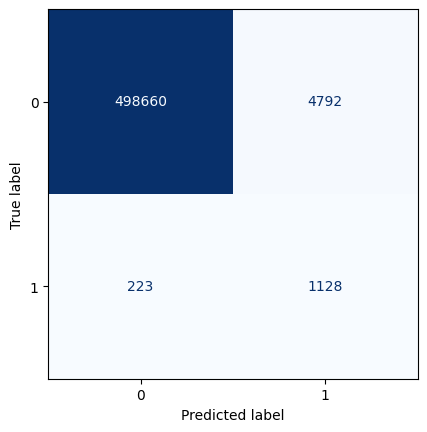

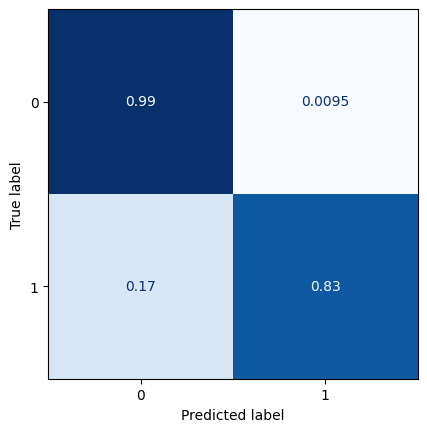

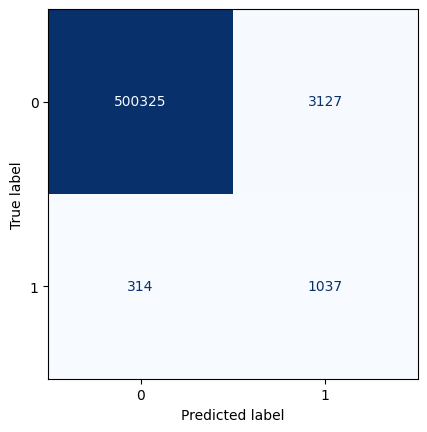

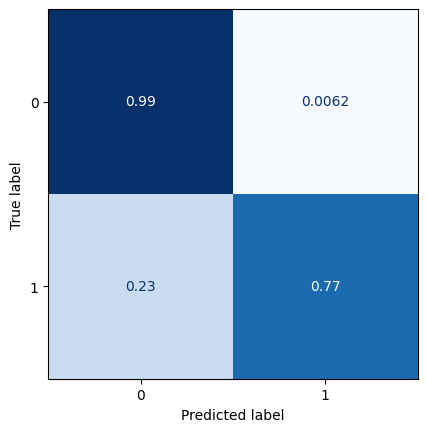

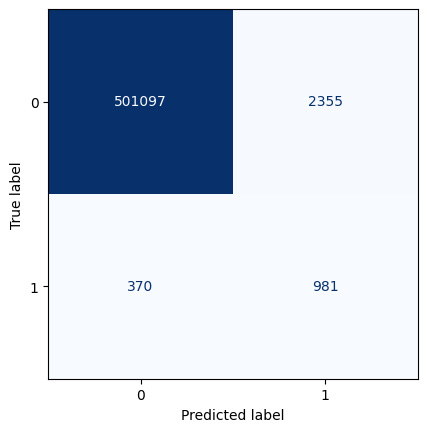

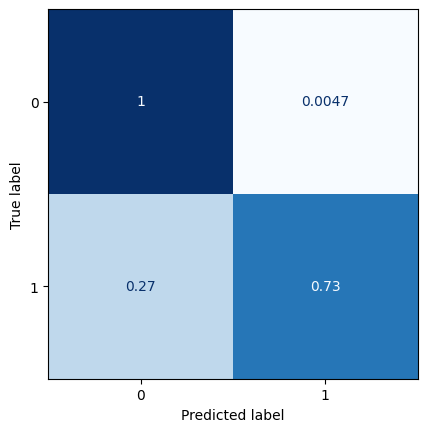

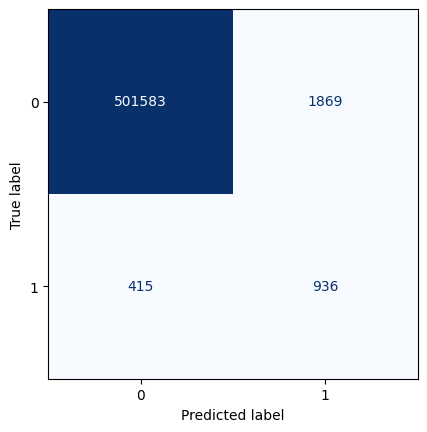

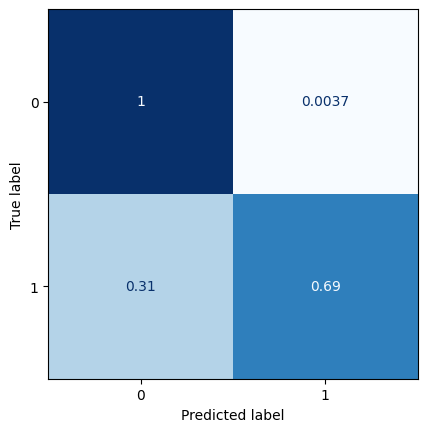

In [22]:
t = model.predict(test_img_std_before20191201[:-1])

ranges = [0.025,0.05,0.075,0.1]

for j in ranges:
    classes = []
    for i in t.reshape(-1,1):
        if i<=j: classes.append(0)
        else: classes.append(1)

# confusion matrix with threshold on 0.1, otherwise always 0 
    ConfusionMatrixDisplay(confusion_matrix(y_test_img_old_24_48[:-1].reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
    ConfusionMatrixDisplay(confusion_matrix(y_test_img_old_24_48[:-1].reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    

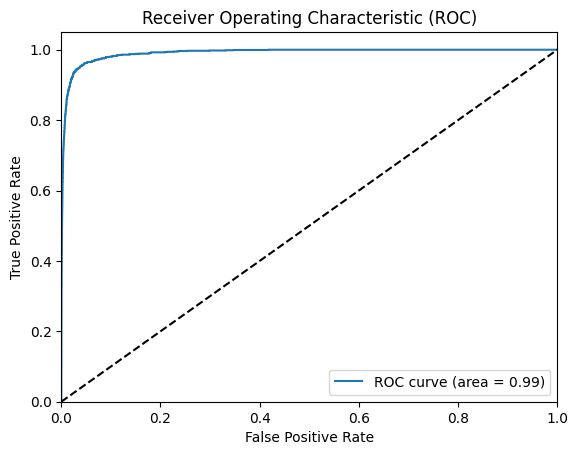

0.001868214872392123
0.0026762915434337753


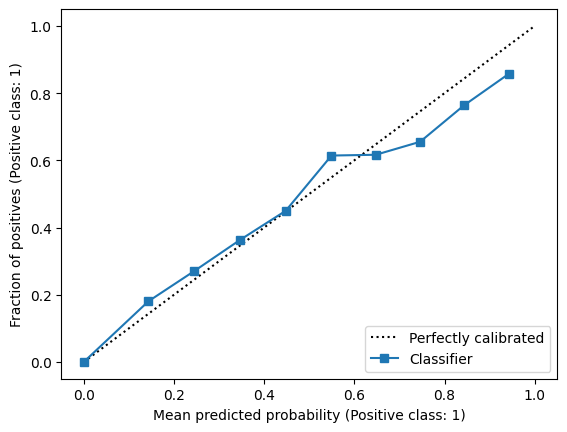

In [23]:
plot_roc(t.reshape(-1,1),y_test_img_old_24_48[:-1].reshape(-1,1))

display = CalibrationDisplay.from_predictions(y_test_img_old_24_48[:-1].reshape(-1,1), t.reshape(-1,1), n_bins=10)

print(brier_score_loss(y_test_img_old_24_48[:-1].reshape(-1,1), t.reshape(-1,1)))
print(brier_score_loss(y_test_img_old_24_48[:-1].reshape(-1,1), np.zeros(len(y_test_img_old_24_48[:-1].reshape(-1,1)))))

## old target, 24 - 48 hours

In [28]:
# class 1 if there is a TC 2 days later

model = Sequential()
model.add(layers.Input(shape=(13, 29, 9)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))

#model.add(layers.Flatten())

#model.add(layers.Reshape((2,4,16)))

model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2,2)))

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')) # sigmoidal activation to have probabilities

model.add(layers.Cropping2D(cropping=((0,1),(0,1))))

model.summary()


model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 13, 29, 8)         656       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 15, 8)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 15, 8)          584       
                                                                 
 up_sampling2d_3 (UpSampling  (None, 14, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 30, 1)         73        
                                                                 
 cropping2d_3 (Cropping2D)   (None, 13, 29, 1)        

In [29]:
model.fit(train_img_std[:-1], y_train_img_old[1:], validation_data=(val_img_std[:-1],y_val_img_old[1:]),
        callbacks=[monitor],epochs=100)

Epoch 1/100


2023-03-21 14:01:57.044638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - ETA: 0s - loss: 0.0417

2023-03-21 14:02:00.241317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - 4s 9ms/step - loss: 0.0417 - val_loss: 0.0106
Epoch 2/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 3/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0097 - val_loss: 0.0085
Epoch 4/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 5/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 6/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 7/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0084 - val_loss: 0.0076
Epoch 8/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 9/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 10/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0080 - val_loss: 0.0073
E

42/42 [==============================] - 0s 4ms/step


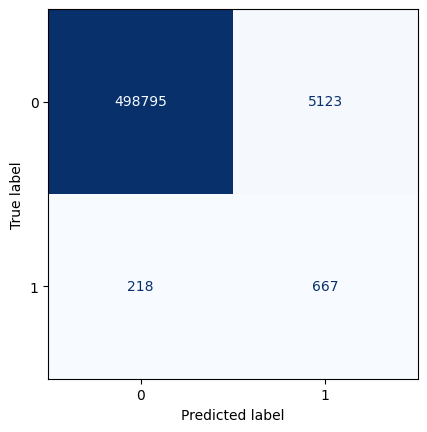

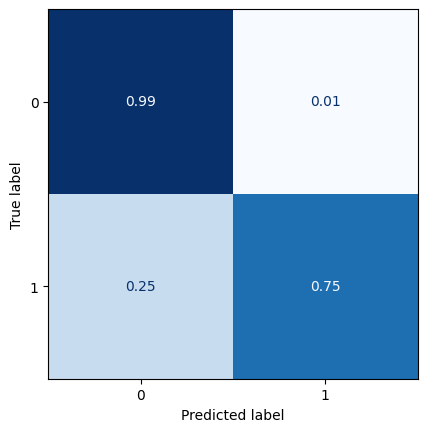

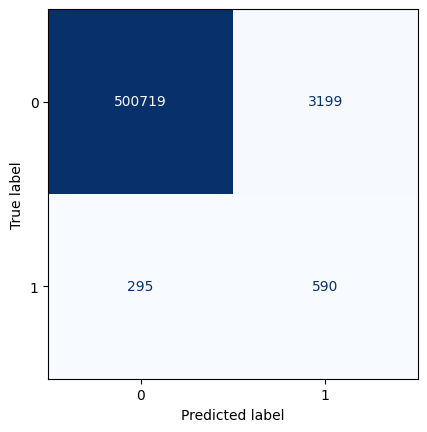

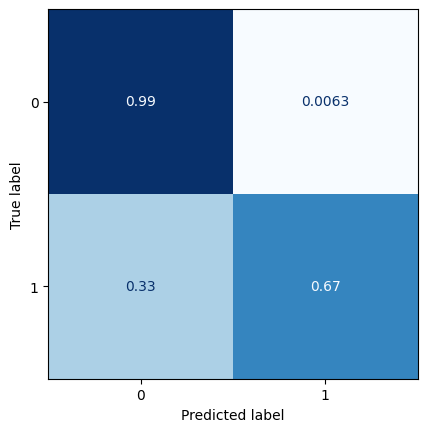

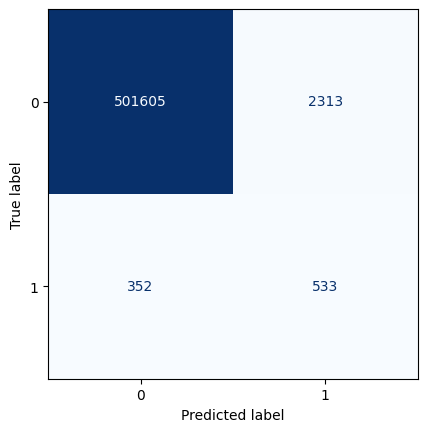

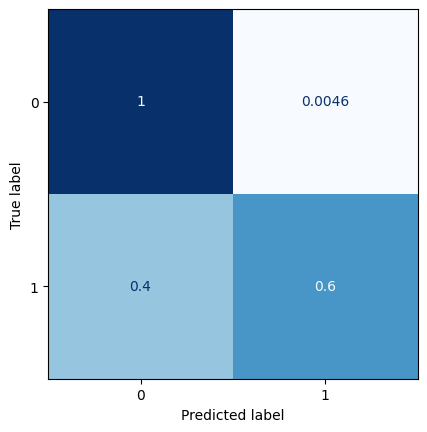

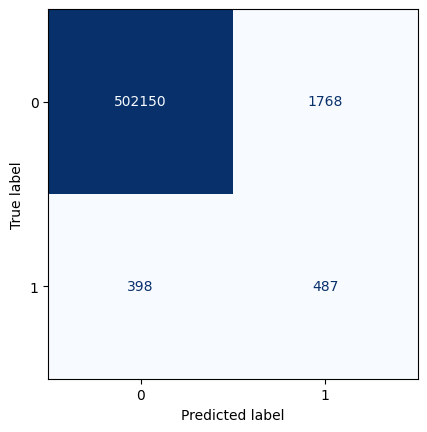

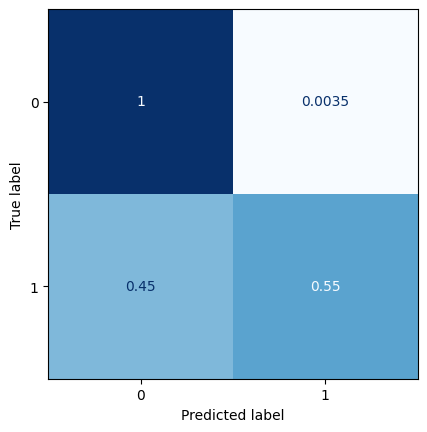

In [32]:
t = model.predict(test_img_std_before20191201[:-1])

ranges = [0.025,0.05,0.075,0.1]

for j in ranges:
    classes = []
    for i in t.reshape(-1,1):
        if i<=j: classes.append(0)
        else: classes.append(1)

# confusion matrix with threshold on 0.1, otherwise always 0 
    ConfusionMatrixDisplay(confusion_matrix(y_test_img_old[1:].reshape(-1,1), classes)).plot(colorbar=False,cmap=plt.cm.Blues, values_format='d')
    ConfusionMatrixDisplay(confusion_matrix(y_test_img_old[1:].reshape(-1,1), classes, normalize='true')).plot(colorbar=False,cmap=plt.cm.Blues)
    

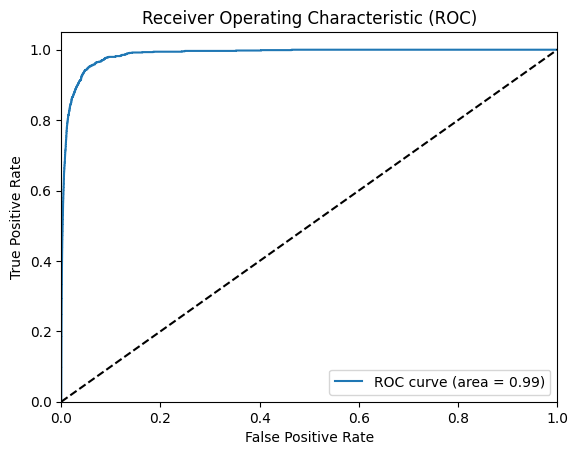

0.0014653005646936008
0.0017531591531746047


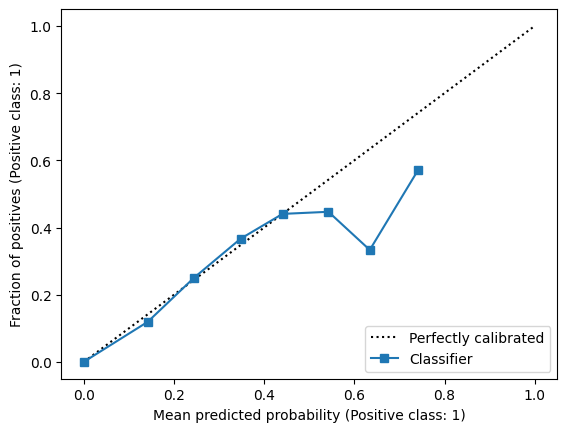

In [33]:
plot_roc(t.reshape(-1,1),y_test_img_old[1:].reshape(-1,1))

display = CalibrationDisplay.from_predictions(y_test_img_old[1:].reshape(-1,1), t.reshape(-1,1), n_bins=10)

print(brier_score_loss(y_test_img_old[1:].reshape(-1,1), t.reshape(-1,1)))
print(brier_score_loss(y_test_img_old[1:].reshape(-1,1), np.zeros(len(y_test_img_old[1:].reshape(-1,1)))))